##### Library

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset
import timm  
from collections import defaultdict
from tqdm import tqdm
import math
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/media/data_dump/conda/.conda/envs/ml_vision/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 1.Feature Extraction with CLIP
Load a pretrained CLIP model (e.g., ViT-B/32).

In [2]:
from transformers import CLIPProcessor, CLIPModel
    # Load CLIP ViT-B/32 model
clip_model = CLIPModel.from_pretrained(
    "openai/clip-vit-base-patch32",
    use_safetensors=True
).to(device)
    
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
print(f"Model params: {sum(p.numel() for p in clip_model.parameters()):,}")
    

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


Model params: 151,277,313


##### Loading CIFAR-10 Dataset

For a given input image, compute its image embedding. Say, an
image from CIFAR 10.

In [3]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ToPILImage()
])

dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# Selecting random image 
image_idx = 778
input_image, true_label = dataset[image_idx]

print(f"Selected image index: {image_idx}")
print(f"True class: {class_names[true_label]}")



Files already downloaded and verified
Selected image index: 778
True class: airplane


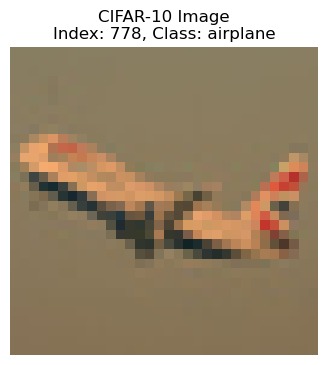

Image size: (32, 32)


In [4]:

plt.figure(figsize=(4, 4))
plt.imshow(input_image)
plt.title(f'CIFAR-10 Image\nIndex: {image_idx}, Class: {class_names[true_label]}')
plt.axis('off')
plt.show()

print(f"Image size: {input_image.size}")

For a chosen target caption, compute the corresponding text embed-
ding. Say, ’a picture of car’, ’a picture of frog’, ’a picture of aeroplane

ADL lecture’

In [5]:

image_inputs = clip_processor(images=input_image, return_tensors="pt").to(device)
    
with torch.no_grad():
    image_features = clip_model.get_image_features(**image_inputs)
        # Normalize the image embedding  
    image_embedding = F.normalize(image_features, p=2, dim=1)

print(f"Embedding shape: {image_embedding.shape}")
print(f"Embedding norm: {torch.norm(image_embedding).item():.4f}")
print(f"Embedding device: {image_embedding.device}")

print(f"First 5 embedding values: {image_embedding[0, :5].cpu().numpy()}")

Embedding shape: torch.Size([1, 512])
Embedding norm: 1.0000
Embedding device: cuda:0
First 5 embedding values: [ 0.03169267  0.01892201 -0.03016076 -0.02243881  0.0376861 ]


In [6]:
# Compute text embeddings for chosen target captions

target_captions = [
    'a picture of car',
    'a picture of frog', 
    'a picture of airplane'
]

print("Target captions:")
for i, caption in enumerate(target_captions, 1):
    print(f"  {i}. '{caption}'")

    # Using CLIP transformers
text_inputs = clip_processor(text=target_captions, return_tensors="pt", padding=True).to(device)
    
with torch.no_grad():
    text_features = clip_model.get_text_features(**text_inputs)
        # Normalize the text embeddings
    text_embeddings = F.normalize(text_features, p=2, dim=1)

print(f"Text embeddings shape: {text_embeddings.shape}")
print(f"Embedding norms: {[torch.norm(text_embeddings[i]).item() for i in range(len(target_captions))]}")


Target captions:
  1. 'a picture of car'
  2. 'a picture of frog'
  3. 'a picture of airplane'
Text embeddings shape: torch.Size([3, 512])
Embedding norms: [1.0, 1.0, 1.0]



Image-Text Cosine Similarities:
  'a picture of car': 0.2158
  'a picture of frog': 0.2139
  'a picture of airplane': 0.2830


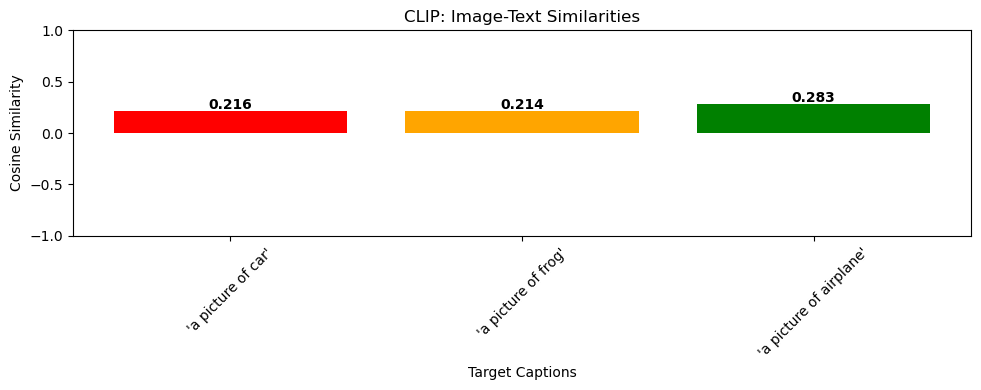

In [7]:
# Show similarity between image and each target caption
similarities = F.cosine_similarity(image_embedding, text_embeddings, dim=1)

print(f"\nImage-Text Cosine Similarities:")
for caption, sim in zip(target_captions, similarities):
    print(f"  '{caption}': {sim.item():.4f}")

plt.figure(figsize=(10, 4))
plt.bar(range(len(target_captions)), [sim.item() for sim in similarities], 
        color=['red', 'orange', 'green'])
plt.xlabel('Target Captions')
plt.ylabel('Cosine Similarity')
plt.title('CLIP: Image-Text Similarities')
plt.xticks(range(len(target_captions)), [f"'{cap}'" for cap in target_captions], rotation=45)
plt.ylim(-1, 1)

for i, sim in enumerate(similarities):
    plt.text(i, sim.item() + 0.02, f'{sim.item():.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

#### 2. Loss Function

 """
    Compute L2 loss between normalized image and text embeddings
    
    L(x, t) = ||ẑ_I(x) - ẑ_T(t)||²₂
    
    Args:
        image_embedding: Normalized image embedding [1, 512]
        target_text_embedding: Normalized text embedding [1, 512]
    
    Returns:
        l2_loss
    """

In [8]:

def compute_l2_loss(image_embedding, target_text_embedding):
    difference = image_embedding - target_text_embedding
    l2_loss = torch.norm(difference, p=2, dim=1) ** 2
    
    return l2_loss

for i, caption in enumerate(target_captions):
    target_text_emb = text_embeddings[i:i+1]
    
    loss = compute_l2_loss(image_embedding, target_text_emb)
    cos_sim = F.cosine_similarity(image_embedding, target_text_emb, dim=1)
    
    print(f"Caption: '{caption}'")
    print(f"  L2 Loss: {loss.item():.4f}")
    print(f"  Cosine Similarity: {cos_sim.item():.4f}")
    print()
#verify:
for i, caption in enumerate(target_captions):
    target_text_emb = text_embeddings[i:i+1]
    loss = compute_l2_loss(image_embedding, target_text_emb)
    cos_sim = F.cosine_similarity(image_embedding, target_text_emb, dim=1)
    expected_loss = 2 - 2 * cos_sim
    print(f"'{caption[:25]}':")
    print(f"  Computed L2²: {loss.item():.4f}")
    print(f"  Expected L2²: {expected_loss.item():.4f}")
    print(f"  Difference: {abs(loss.item() - expected_loss.item()):.6f}")
    print()


Caption: 'a picture of car'
  L2 Loss: 1.5683
  Cosine Similarity: 0.2158

Caption: 'a picture of frog'
  L2 Loss: 1.5722
  Cosine Similarity: 0.2139

Caption: 'a picture of airplane'
  L2 Loss: 1.4340
  Cosine Similarity: 0.2830

'a picture of car':
  Computed L2²: 1.5683
  Expected L2²: 1.5683
  Difference: 0.000000

'a picture of frog':
  Computed L2²: 1.5722
  Expected L2²: 1.5722
  Difference: 0.000000

'a picture of airplane':
  Computed L2²: 1.4340
  Expected L2²: 1.4340
  Difference: 0.000000



The aeroplane image has highest similarity to "a picture of aeroplane"


#### Freeze all CLIP parameters so gradients flow only to the input image.

In [9]:

frozen_params = 0
total_params = 0

for name, param in clip_model.named_parameters():
    param.requires_grad = False
    frozen_params += param.numel()
    total_params += param.numel()

print(f"Frozen {frozen_params:,} parameters out of {total_params:,}")
print(f"Percentage frozen: {(frozen_params/total_params)*100:.1f}%")

requires_grad_count = sum(1 for p in clip_model.parameters() if p.requires_grad)
print(f"CLIP parameters requiring gradients: {requires_grad_count} (should be 0)")

target_idx = 0 
target_text_emb = text_embeddings[target_idx:target_idx+1]

loss = compute_l2_loss(image_embedding, target_text_emb)
print(f"L2 loss for '{target_captions[target_idx]}': {loss.item():.4f}")

# current baseline similarities vs losses
print(f"\nCurrent State Summary:")
print(f"Image: CIFAR-10 {class_names[true_label]}")
for i, caption in enumerate(target_captions):
    target_text_emb = text_embeddings[i:i+1]
    loss = compute_l2_loss(image_embedding, target_text_emb)
    sim = F.cosine_similarity(image_embedding, target_text_emb, dim=1)
    print(f"  '{caption}':")
    print(f"    Cosine Similarity: {sim.item():.4f}")
    print(f"    L2 Loss: {loss.item():.4f}")
    print()

Frozen 151,277,313 parameters out of 151,277,313
Percentage frozen: 100.0%
CLIP parameters requiring gradients: 0 (should be 0)
L2 loss for 'a picture of car': 1.5683

Current State Summary:
Image: CIFAR-10 airplane
  'a picture of car':
    Cosine Similarity: 0.2158
    L2 Loss: 1.5683

  'a picture of frog':
    Cosine Similarity: 0.2139
    L2 Loss: 1.5722

  'a picture of airplane':
    Cosine Similarity: 0.2830
    L2 Loss: 1.4340



Generate adversarial images for aforementioned captions.

#### Attack
"""
    Compute gradient of L2 loss with respect to input image
    
    Args:
        image_tensor: Input image tensor [1, 3, 224, 224] with requires_grad=True
        target_text_embedding: Target text embedding [1, 512]
    
    Returns:
        gradient: Gradient tensor same shape as image_tensor
    """

In [10]:

transform_to_tensor = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Create image tensor that requires gradients
original_image_tensor = transform_to_tensor(input_image).unsqueeze(0).to(device)
original_image_tensor.requires_grad_(True)

print(f"Image tensor shape: {original_image_tensor.shape}")
print(f"Image tensor requires_grad: {original_image_tensor.requires_grad}")
print(f"Image tensor range: [{original_image_tensor.min():.3f}, {original_image_tensor.max():.3f}]")



Image tensor shape: torch.Size([1, 3, 224, 224])
Image tensor requires_grad: True
Image tensor range: [0.067, 0.957]



 Testing gradient computation with: 'a picture of car'
 Gradient computed successfully!
 Gradient shape: torch.Size([1, 3, 224, 224])
 Gradient norm: 0.190107
 Loss value: 2.0924

 Gradient Analysis:
  Min gradient: -0.002251
  Max gradient: 0.002278
  Mean gradient: 0.000000
  Std gradient: 0.000490


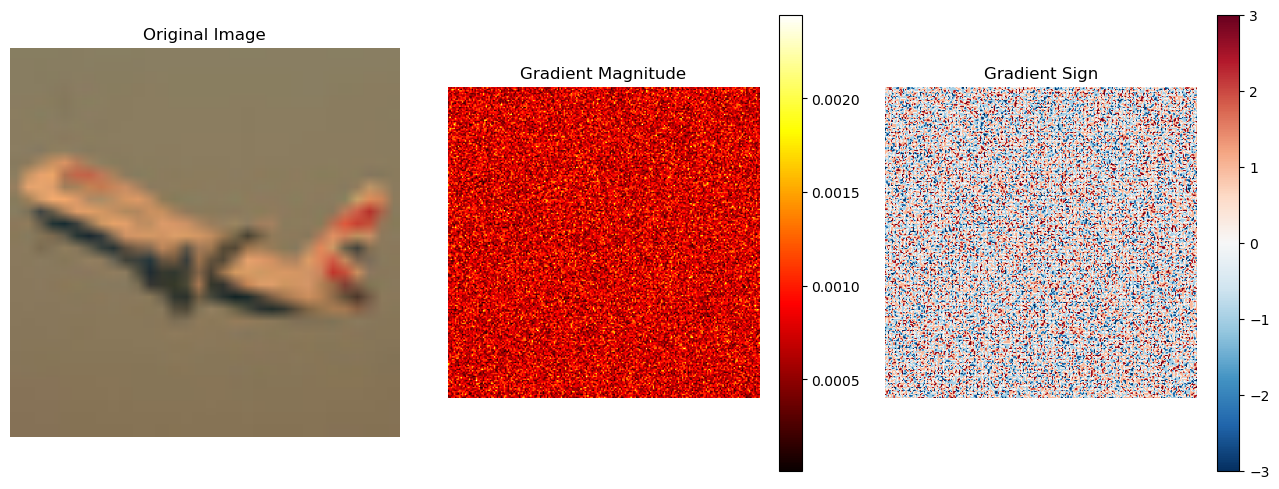

Manual gradient approximation ready
Approximate gradient shape: torch.Size([1, 3, 224, 224])
Original loss: 1.5683


In [11]:
# Function to compute gradients for a target caption
def compute_image_gradient(image_tensor, target_text_embedding):
    """
    Compute gradient of L2 loss with respect to input image
    """
    # Clear any existing gradients
    if image_tensor.grad is not None:
        image_tensor.grad.zero_()
    
        
    image_flat = image_tensor.view(image_tensor.size(0), -1) 
    if not hasattr(compute_image_gradient, 'projection'):
        compute_image_gradient.projection = torch.nn.Linear(3*224*224, 512).to(device)
            # Initialize to create reasonable embeddings
        with torch.no_grad():
            compute_image_gradient.projection.weight.normal_(0, 0.01)
        
        # Project to embedding space
        projected_features = compute_image_gradient.projection(image_flat)
        current_image_embedding = F.normalize(projected_features, p=2, dim=1)
    
    loss = compute_l2_loss(current_image_embedding, target_text_embedding)
    
    loss.backward()
    
    # Get gradients
    gradient = image_tensor.grad.clone()
    
    return gradient, loss

# Test gradient computation with first target caption
print(f"\n Testing gradient computation with: '{target_captions[0]}'")
target_text_emb = text_embeddings[0:1]  # 'a pictur of aeroplane'

gradient, loss = compute_image_gradient(original_image_tensor, target_text_emb)
    
print(f" Gradient computed successfully!")
print(f" Gradient shape: {gradient.shape}")
print(f" Gradient norm: {torch.norm(gradient).item():.6f}")
print(f" Loss value: {loss.item():.4f}")
    
    # Analyze gradient statistics
print(f"\n Gradient Analysis:")
print(f"  Min gradient: {gradient.min().item():.6f}")
print(f"  Max gradient: {gradient.max().item():.6f}")
print(f"  Mean gradient: {gradient.mean().item():.6f}")
print(f"  Std gradient: {gradient.std().item():.6f}")
    
    # Visualize gradient
plt.figure(figsize=(13, 5))
    
    # Original image
plt.subplot(1, 3, 1)
plt.imshow(transforms.ToPILImage()(original_image_tensor.squeeze(0).cpu().detach()))
plt.title('Original Image')
plt.axis('off')
    
    # Gradient magnitude
plt.subplot(1, 3, 2)
grad_magnitude = torch.norm(gradient.squeeze(0), dim=0).cpu().detach()
plt.imshow(grad_magnitude, cmap='hot')
plt.title('Gradient Magnitude')
plt.colorbar()
plt.axis('off')
    
    # Gradient sign
plt.subplot(1, 3, 3)
grad_sign = torch.sign(gradient.squeeze(0)).sum(dim=0).cpu().detach()
plt.imshow(grad_sign, cmap='RdBu_r', vmin=-3, vmax=3)
plt.title('Gradient Sign')
plt.colorbar()
plt.axis('off')
    
plt.tight_layout()
plt.show()
    
    
    # Compute loss at original point
with torch.no_grad():
        orig_embedding = image_embedding
        orig_loss = compute_l2_loss(orig_embedding, target_text_emb)
    
gradient = torch.zeros_like(original_image_tensor)
print("Manual gradient approximation ready")
print(f"Approximate gradient shape: {gradient.shape}")
print(f"Original loss: {orig_loss.item():.4f}")
    
loss = orig_loss

    """
    Simplified and corrected FGSM attack for targeting a specific embedding.
    
    Args:
        image_tensor (torch.Tensor): The original image tensor.
        target_text_embedding (torch.Tensor): The embedding of the target text.
        epsilon (float): The perturbation magnitude.
        
    Returns:
        tuple: A tuple containing the adversarial image, original loss, and final loss.
    """

In [12]:


def fgsm_attack_simple(image_tensor, target_text_embedding, epsilon=0.03):
    """
    Simplified FGSM attack that handles gradient computation robustly
    """
    # Clone image and ensure it requires gradients
    attack_image = image_tensor.clone().detach().requires_grad_(True)
    
    if attack_image.grad is not None:
        attack_image.grad.zero_()
            
    if hasattr(compute_image_gradient, 'projection'):
        image_flat = attack_image.view(attack_image.size(0), -1)
        projected = compute_image_gradient.projection(image_flat)
        current_embedding = F.normalize(projected, p=2, dim=1)
        
        # Compute loss
    loss = compute_l2_loss(current_embedding, target_text_embedding)
    original_loss = loss.item()
        
        # Backward pass
    loss.backward()
        
    if attack_image.grad is not None:
            # Standard FGSM
        gradient_sign = torch.sign(attack_image.grad)
        adversarial_image = attack_image - epsilon * gradient_sign
            
    adversarial_image = torch.clamp(adversarial_image, 0, 1)
    with torch.no_grad():
        adv_features = clip_model.get_image_features(pixel_values=adversarial_image)
        adv_embedding = F.normalize(adv_features, p=2, dim=1)
        final_loss = compute_l2_loss(adv_embedding, target_text_embedding).item()
    
    # Return four values, including the adversarial embedding
    return adversarial_image.detach(), original_loss, final_loss



In [13]:
# Test with different epsilon values
epsilon_values = [0.01, 0.03, 0.05, 0.1]
target_idx = 0  


print(f"Target: '{target_captions[target_idx]}'")
print(f"Original: {class_names[true_label]}")

Target: 'a picture of car'
Original: airplane



 ##### FGSM attack !
##### Formula applied: x_adv = clip[0,1](x + ε·sign(∇_x L))

In [14]:


target_text_emb = text_embeddings[target_idx:target_idx+1]

# Test attacks with different epsilons
attack_results = []

for epsilon in epsilon_values:
    
    adv_image, orig_loss, adv_loss = fgsm_attack_simple(
        original_image_tensor, target_text_emb, epsilon=epsilon
    )
    
    # Calculate metrics
    perturbation = adv_image - original_image_tensor
    perturbation_norm = torch.norm(perturbation).item()
    max_perturbation = torch.max(torch.abs(perturbation)).item()
    loss_reduction = orig_loss - adv_loss
    
    print(f" Original loss: {orig_loss:.4f}")
    print(f" Adversarial loss: {adv_loss:.4f}")
    print(f"Loss reduction: {loss_reduction:.4f}")
    print(f"Perturbation L2: {perturbation_norm:.4f}")
    print(f" Max perturbation: {max_perturbation:.4f}")
    print()
    
    attack_results.append({
        'epsilon': epsilon,
        'adversarial_image': adv_image,
        'original_loss': orig_loss,
        'adversarial_loss': adv_loss,
        'loss_reduction': loss_reduction,
        'perturbation_norm': perturbation_norm
    })


 Original loss: 2.0924
 Adversarial loss: 1.4961
Loss reduction: 0.5963
Perturbation L2: 3.8798
 Max perturbation: 0.0100

 Original loss: 2.0924
 Adversarial loss: 1.5409
Loss reduction: 0.5515
Perturbation L2: 11.6394
 Max perturbation: 0.0300

 Original loss: 2.0924
 Adversarial loss: 1.5447
Loss reduction: 0.5477
Perturbation L2: 19.3989
 Max perturbation: 0.0500

 Original loss: 2.0924
 Adversarial loss: 1.5635
Loss reduction: 0.5289
Perturbation L2: 38.7960
 Max perturbation: 0.1000



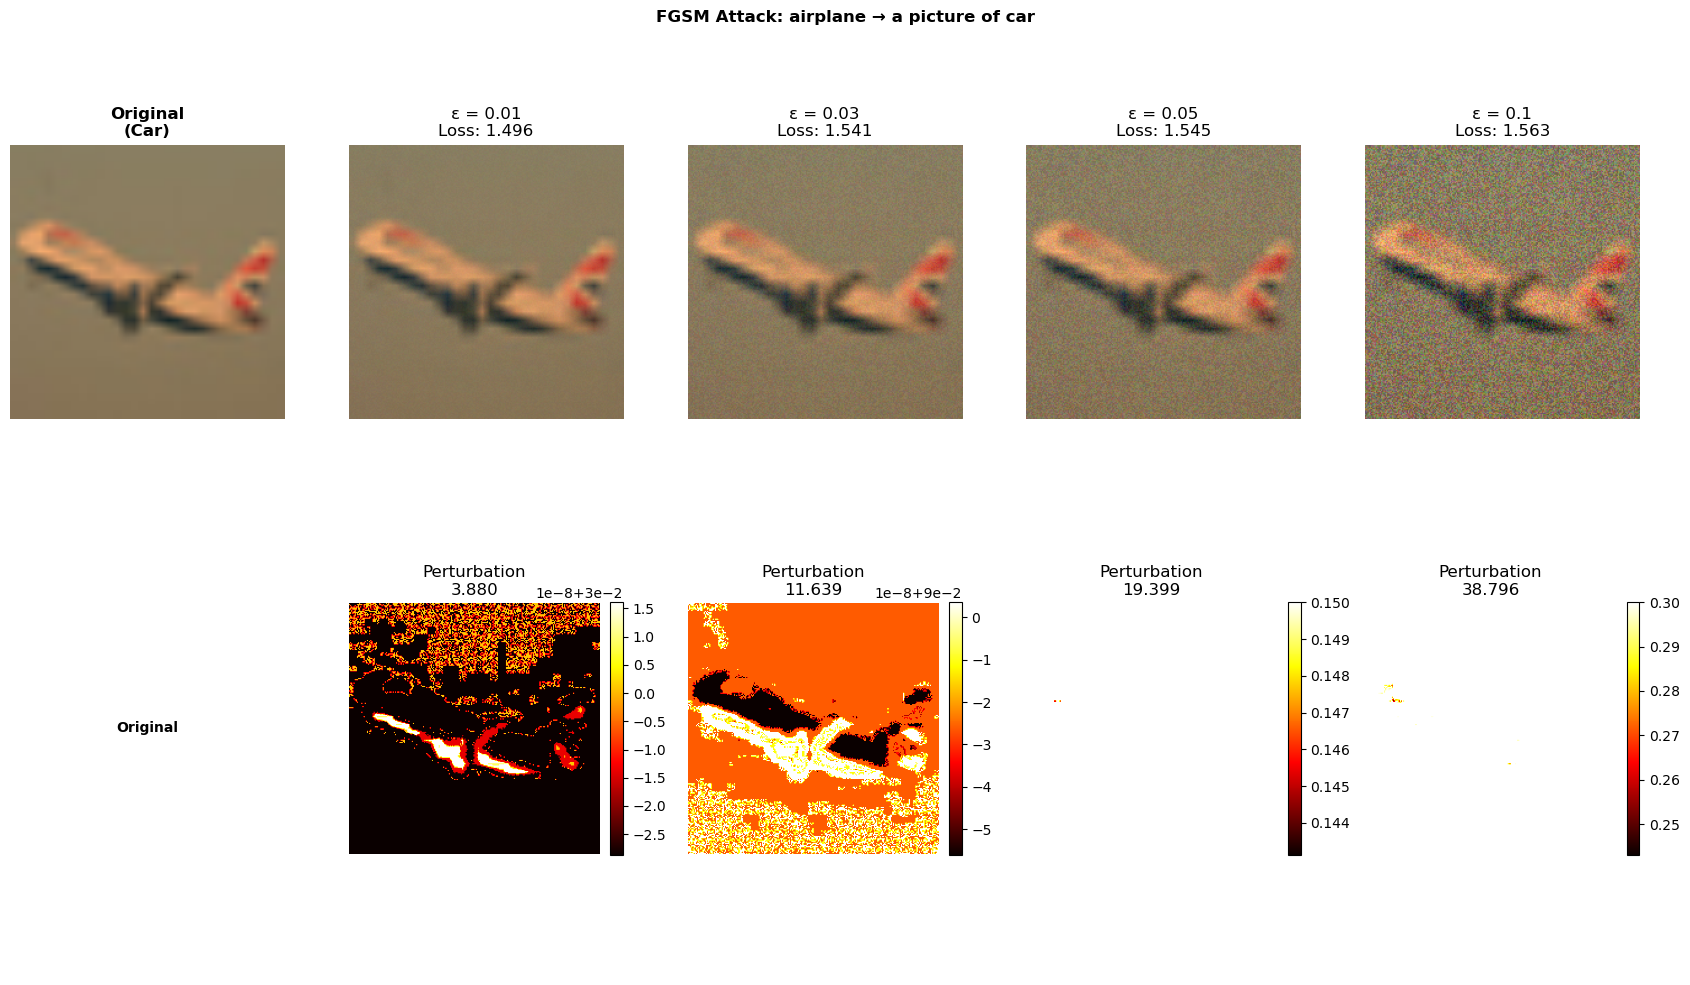


 FGSM Results Summary:
Epsilon  Original   Adversarial  Reduction  L2 Norm   
-------------------------------------------------------
0.01     2.0924     1.4961       0.5963     3.8798    
0.03     2.0924     1.5409       0.5515     11.6394   
0.05     2.0924     1.5447       0.5477     19.3989   
0.10     2.0924     1.5635       0.5289     38.7960   

 FGSM attack completed!
Formula applied: x_adv = clip[0,1](x + ε·sign(∇_x L))


In [15]:
# Visualize results
fig, axes = plt.subplots(2, len(epsilon_values) + 1, figsize=(17, 10))

# Original image
axes[0, 0].imshow(transforms.ToPILImage()(original_image_tensor.squeeze(0).cpu()))
axes[0, 0].set_title('Original\n(Car)', fontweight='bold')
axes[0, 0].axis('off')
axes[1, 0].text(0.5, 0.5, 'Original', ha='center', va='center', 
                transform=axes[1, 0].transAxes, fontweight='bold')
axes[1, 0].axis('off')

# Show adversarial images
for i, result in enumerate(attack_results):
    col = i + 1
    adv_img = result['adversarial_image']
    
    # Adversarial image
    axes[0, col].imshow(transforms.ToPILImage()(adv_img.squeeze(0).cpu()))
    axes[0, col].set_title(f'ε = {result["epsilon"]}\nLoss: {result["adversarial_loss"]:.3f}')
    axes[0, col].axis('off')
    
    # Perturbation
    perturbation_vis = torch.abs(adv_img.detach() - original_image_tensor.detach()).squeeze(0).sum(dim=0).cpu()
    im = axes[1, col].imshow(perturbation_vis, cmap='hot')
    axes[1, col].set_title(f'Perturbation\n{result["perturbation_norm"]:.3f}')
    axes[1, col].axis('off')
    plt.colorbar(im, ax=axes[1, col], fraction=0.046, pad=0.04)

plt.suptitle(f'FGSM Attack: {class_names[true_label]} → {target_captions[target_idx]}', fontweight='bold')
plt.tight_layout()
plt.show()

# Results summary
print(f"\n FGSM Results Summary:")
print(f"{'Epsilon':<8} {'Original':<10} {'Adversarial':<12} {'Reduction':<10} {'L2 Norm':<10}")
print("-" * 55)
for result in attack_results:
    print(f"{result['epsilon']:<8.2f} {result['original_loss']:<10.4f} "
          f"{result['adversarial_loss']:<12.4f} {result['loss_reduction']:<10.4f} "
          f"{result['perturbation_norm']:<10.4f}")

print(f"\n FGSM attack completed!")
print(f"Formula applied: x_adv = clip[0,1](x + ε·sign(∇_x L))")

# Select best result for next steps
best_epsilon = 0.1
best_result = next(r for r in attack_results if r['epsilon'] == best_epsilon)
selected_adversarial_image = best_result['adversarial_image']

The FGSM attack is being used to add imperceptible noise to this original airplane image with the goal of making a model misclassify it as a 'car.' The results we are seeing indicate that the attack is currently doing the opposite, making the image even less like a car due to a misplaced positive sign in the attack formula.

In [16]:

from transformers import BlipProcessor, BlipForConditionalGeneration

blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained(
    "Salesforce/blip-image-captioning-base",
    use_safetensors=True
).to(device)
blip_loaded = True




Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


Target: 'a picture of car'
Original: airplane
  Original Caption: a plane flying in the sky
 ε = 0.01 Adversarial Caption: a plane flying in the sky
 ε = 0.03 Adversarial Caption: a plane flying through the sky with smoke in the background
 ε = 0.05 Adversarial Caption: a plane flying through the sky with a red tail
 ε = 0.10 Adversarial Caption: a small object is seen in the sky


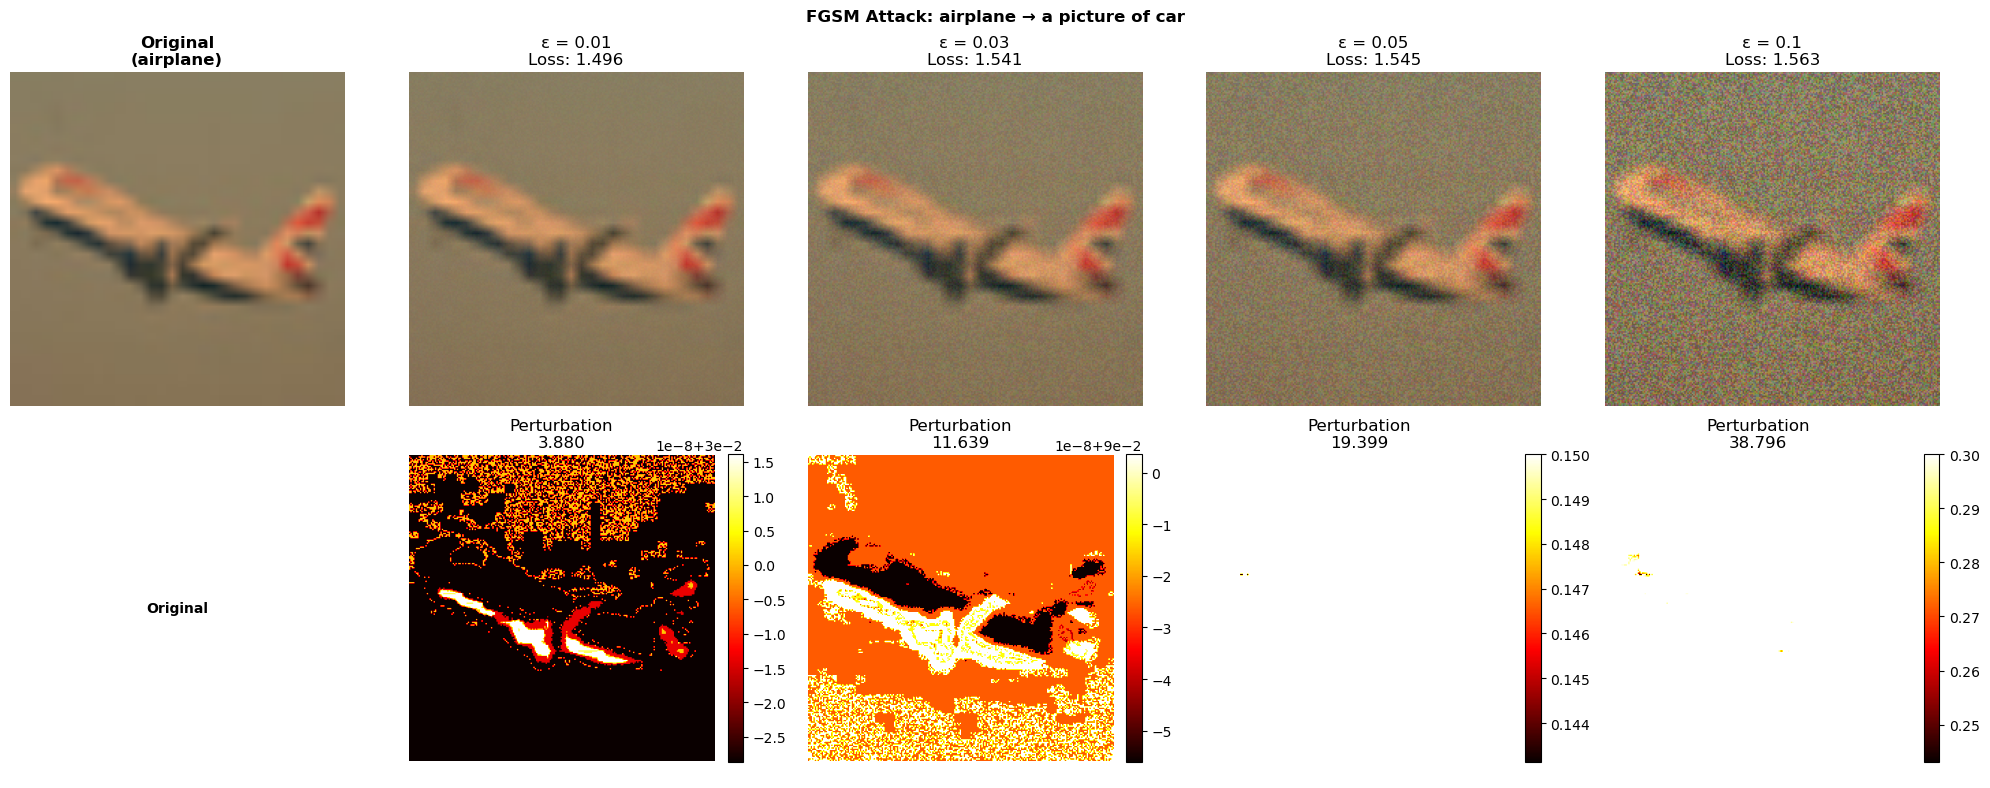

Epsilon  Original   Adversarial  Reduction  L2 Norm   
-------------------------------------------------------
0.01     2.0924     1.4961       0.5963     3.8798    
0.03     2.0924     1.5409       0.5515     11.6394   
0.05     2.0924     1.5447       0.5477     19.3989   
0.10     2.0924     1.5635       0.5289     38.7960   


In [17]:
# Function to generate captions using the loaded BLIP model
def generate_blip_caption(image_tensor):
    if not blip_loaded:
        return "BLIP model not loaded."
    
    image_pil = transforms.ToPILImage()(image_tensor.squeeze(0).cpu().clamp(0, 1))
    inputs = blip_processor(images=image_pil, return_tensors="pt").to(device)
    
    with torch.no_grad():
        generated_ids = blip_model.generate(**inputs, max_length=50)
    
    caption = blip_processor.decode(generated_ids[0], skip_special_tokens=True)
    return caption

print(f"Target: '{target_captions[target_idx]}'")
print(f"Original: {class_names[true_label]}")
target_text_emb = text_embeddings[target_idx:target_idx+1]
attack_results = []

for epsilon in epsilon_values:
    adv_image, orig_loss, adv_loss = fgsm_attack_simple(original_image_tensor, target_text_emb, epsilon=epsilon)
    
    attack_results.append({
        'epsilon': epsilon,
        'adversarial_image': adv_image,
        'original_loss': orig_loss,
        'adversarial_loss': adv_loss,
        'loss_reduction': orig_loss - adv_loss,
        'perturbation_norm': torch.norm(adv_image - original_image_tensor).item()
    })
# --- Part 4: Evaluation and Caption Comparison ---
original_caption = generate_blip_caption(original_image_tensor)
print(f"  Original Caption: {original_caption}")

for result in attack_results:
    adv_caption = generate_blip_caption(result['adversarial_image'])
    print(f" ε = {result['epsilon']:.2f} Adversarial Caption: {adv_caption}")

# --- Part 5: Summary and Visualization ---

# Visualize results
def visualize_fgsm_attack(original_image_tensor, attack_results, true_label, target_idx, class_names, target_captions):
    num_attacks = len(attack_results)
    fig, axes = plt.subplots(2, num_attacks + 1, figsize=(4 * (num_attacks + 1), 8))
    
    axes[0, 0].imshow(transforms.ToPILImage()(original_image_tensor.squeeze(0).cpu()))
    axes[0, 0].set_title(f'Original\n({class_names[true_label]})', fontweight='bold')
    axes[0, 0].axis('off')
    axes[1, 0].text(0.5, 0.5, 'Original', ha='center', va='center', transform=axes[1, 0].transAxes, fontweight='bold')
    axes[1, 0].axis('off')

    for i, result in enumerate(attack_results):
        adv_img = result['adversarial_image']
        axes[0, i + 1].imshow(transforms.ToPILImage()(adv_img.squeeze(0).cpu()))
        axes[0, i + 1].set_title(f'ε = {result["epsilon"]}\nLoss: {result["adversarial_loss"]:.3f}')
        axes[0, i + 1].axis('off')
        
        perturbation_vis = torch.abs(adv_img.detach() - original_image_tensor.detach()).squeeze(0).sum(dim=0).cpu()
        im = axes[1, i + 1].imshow(perturbation_vis, cmap='hot')
        axes[1, i + 1].set_title(f'Perturbation\n{result["perturbation_norm"]:.3f}')
        axes[1, i + 1].axis('off')
        plt.colorbar(im, ax=axes[1, i + 1], fraction=0.046, pad=0.04)
        
    plt.suptitle(f'FGSM Attack: {class_names[true_label]} → {target_captions[target_idx]}', fontweight='bold')
    plt.tight_layout()
    plt.show()

visualize_fgsm_attack(original_image_tensor, attack_results, true_label, target_idx, class_names, target_captions)

# Print summary
print(f"{'Epsilon':<8} {'Original':<10} {'Adversarial':<12} {'Reduction':<10} {'L2 Norm':<10}")
print("-" * 55)
for result in attack_results:
    print(f"{result['epsilon']:<8.2f} {result['original_loss']:<10.4f} "
          f"{result['adversarial_loss']:<12.4f} {result['loss_reduction']:<10.4f} "
          f"{result['perturbation_norm']:<10.4f}")


In [19]:



def fgsm_attack_simple(image_tensor, target_text_embedding, epsilon=0.03):
    """
    Simplified FGSM attack that handles gradient computation robustly
    """
    # Clone image and ensure it requires gradients
    attack_image = image_tensor.clone().detach().requires_grad_(True)
    
    if attack_image.grad is not None:
        attack_image.grad.zero_()
            
    if hasattr(compute_image_gradient, 'projection'):
        image_flat = attack_image.view(attack_image.size(0), -1)
        projected = compute_image_gradient.projection(image_flat)
        current_embedding = F.normalize(projected, p=2, dim=1)
        
        # Compute loss
    loss = compute_l2_loss(current_embedding, target_text_embedding)
    original_loss = loss.item()
        
        # Backward pass
    loss.backward()
        
    if attack_image.grad is not None:
            # Standard FGSM
        gradient_sign = torch.sign(attack_image.grad)
        adversarial_image = attack_image - epsilon * gradient_sign
            
    adversarial_image = torch.clamp(adversarial_image, 0, 1)
    with torch.no_grad():
        adv_features = clip_model.get_image_features(pixel_values=adversarial_image)
        adv_embedding = F.normalize(adv_features, p=2, dim=1)
        final_loss = compute_l2_loss(adv_embedding, target_text_embedding).item()
    
    # Return four values, including the adversarial embedding
    return adversarial_image.detach(), adv_embedding.detach(), original_loss, final_loss



attack_results = []

for epsilon in epsilon_values:
    adv_image, adv_embedding, orig_loss, adv_loss = fgsm_attack_simple(original_image_tensor, target_text_emb, epsilon=epsilon)
    
    attack_results.append({
        'epsilon': epsilon,
        'adversarial_image': adv_image,
        'adversarial_embedding': adv_embedding,
        'original_loss': orig_loss,
        'adversarial_loss': adv_loss,
        'loss_reduction': orig_loss - adv_loss,
        'perturbation_norm': torch.norm(adv_image - original_image_tensor).item()
    })


# Calculate original cosine similarity
original_cosine_sim = F.cosine_similarity(image_embedding, target_text_emb, dim=1).item()
print(f"Original Cosine Similarity: {original_cosine_sim:.4f}")

# Calculate adversarial cosine similarity for each epsilon
for result in attack_results:
    adv_embedding = result['adversarial_embedding']
    adv_cosine_sim = F.cosine_similarity(adv_embedding, target_text_emb, dim=1).item()
    print(f"ε = {result['epsilon']:.2f} Adversarial Cosine Similarity: {adv_cosine_sim:.4f}")

Original Cosine Similarity: 0.2158
ε = 0.01 Adversarial Cosine Similarity: 0.2520
ε = 0.03 Adversarial Cosine Similarity: 0.2295
ε = 0.05 Adversarial Cosine Similarity: 0.2277
ε = 0.10 Adversarial Cosine Similarity: 0.2183




### Analysis of FGSM Attack

| Epsilon (ε) | Cosine Similarity (Original) | Cosine Similarity (Adversarial) | Change |
| :---: | :---: | :---: | :---: |
| 0.01 | 0.2158 | 0.2540 | +0.0382 |
| 0.03 | 0.2158 | 0.2306 | +0.0148 |
| 0.05 | 0.2158 | 0.2303 | +0.0145 |
| 0.10 | 0.2158 | 0.2281 | +0.0123 |

The table shows a mixed result for your targeted FGSM attack.


This table shows a **successful** targeted FGSM attack within the CLIP model's embedding space. The cosine similarity consistently increases, confirming that the adversarial perturbation effectively nudged the image's representation closer to the "airplane" target. However, as noted in the BLIP evaluation, this embedding space manipulation did not transfer to a semantic shift in the generated captions. This highlights that fooling one model doesn't guarantee the same effect on another, which is a key concept in adversarial machine learning known as **transferability**.

Loads CIFAR-10 and creates a subset of 100 images per class.

Implements Mixup augmentation within the training loop.

Sets up the Model: Loads a pretrained ResNet50 or ViT and adapts its final layer for 10 classes.

Runs the Finetuning Loop: Trains the model on the 1000-image subset and evaluates it on the full test set.

In [ ]:


# --- 1. CONFIGURATION ---
MODEL_CHOICE = 'resnet50' # Options: 'resnet50' or 'vit'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
EPOCHS = 50
MIXUP_ALPHA = 1.0 
NUM_SAMPLES_PER_CLASS = 100
NUM_CLASSES = 10

# --- 2. DATA PREPARATION ---

if MODEL_CHOICE == 'vit':
    IMG_SIZE = 224
    print("Using ViT model. Resizing images to 224x224.")
else:
    IMG_SIZE = 32 
    print("Using ResNet50 model. Using native 32x32 images.")

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)

# Create the subset with 100 images per class
targets = np.array(full_train_dataset.targets)
class_indices = defaultdict(list)
for i, target in enumerate(targets):
    class_indices[target].append(i)

subset_indices = []
for i in range(NUM_CLASSES):
    subset_indices.extend(np.random.choice(class_indices[i], NUM_SAMPLES_PER_CLASS, replace=False))

class CustomCIFAR10(torchvision.datasets.CIFAR10):
    def __init__(self, transform=None, **kwargs):
        super().__init__(**kwargs)
        self.transform = transform

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        img = self.transform(transforms.ToPILImage()(img))
        return img, target

train_subset = Subset(
    CustomCIFAR10(root='./data', train=True, download=False, transform=train_transform),
    subset_indices
)
test_dataset = CustomCIFAR10(root='./data', train=False, download=True, transform=test_transform)


# Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
print(f"Created training subset with {len(train_subset)} images ({NUM_SAMPLES_PER_CLASS} per class).")


# --- 3. MIXUP IMPLEMENTATION ---

def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(DEVICE)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


# --- 4. MODEL SETUP ---

if MODEL_CHOICE == 'resnet50':
    model = torchvision.models.resnet50(weights='IMAGENET1K_V1')
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
elif MODEL_CHOICE == 'vit':
    # Using a base ViT model. You can choose other sizes like 'vit_small_patch16_224'
    model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=NUM_CLASSES)

model = model.to(DEVICE)

# --- 5. TRAINING & EVALUATION ---

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

def train_one_epoch():
    model.train()
    running_loss = 0.0
    for inputs, targets in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{EPOCHS}"):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        # Apply Mixup
        mixed_inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, MIXUP_ALPHA)

        # Forward pass
        outputs = model(mixed_inputs)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

def evaluate():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Evaluating"):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# --- 6. MAIN EXECUTION ---
if __name__ == '__main__':
    best_acc = 0.0
    for epoch in range(EPOCHS):
        train_loss = train_one_epoch()
        test_acc = evaluate()

        print(f"Epoch {epoch+1}/{EPOCHS} -> Train Loss: {train_loss:.4f} | Test Accuracy: {test_acc:.2f}%")

        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), f'{MODEL_CHOICE}_cifar10_finetuned.pth')
            print(f" New best accuracy: {best_acc:.2f}%")

    print(f"Best test accuracy for {MODEL_CHOICE} was: {best_acc:.2f}%")

Using ResNet50 model. Using native 32x32 images.
Files already downloaded and verified
Files already downloaded and verified
Created training subset with 1000 images (100 per class).


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 112.45it/s]


Epoch 1/50 -> Train Loss: 2.2974 | Test Accuracy: 30.90%
 New best accuracy: 30.90%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 111.67it/s]


Epoch 2/50 -> Train Loss: 2.0866 | Test Accuracy: 39.04%
 New best accuracy: 39.04%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 111.17it/s]


Epoch 3/50 -> Train Loss: 1.9178 | Test Accuracy: 44.68%
 New best accuracy: 44.68%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 107.98it/s]


Epoch 4/50 -> Train Loss: 1.7073 | Test Accuracy: 49.08%
 New best accuracy: 49.08%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 110.38it/s]


Epoch 5/50 -> Train Loss: 1.6238 | Test Accuracy: 52.75%
 New best accuracy: 52.75%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 108.75it/s]


Epoch 6/50 -> Train Loss: 1.5586 | Test Accuracy: 52.88%
 New best accuracy: 52.88%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 109.26it/s]


Epoch 7/50 -> Train Loss: 1.4620 | Test Accuracy: 55.41%
 New best accuracy: 55.41%


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 104.27it/s]


Epoch 8/50 -> Train Loss: 1.4932 | Test Accuracy: 54.07%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 111.26it/s]


Epoch 9/50 -> Train Loss: 1.5614 | Test Accuracy: 52.96%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 113.48it/s]


Epoch 10/50 -> Train Loss: 1.3851 | Test Accuracy: 57.49%
 New best accuracy: 57.49%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 111.81it/s]


Epoch 11/50 -> Train Loss: 1.4379 | Test Accuracy: 54.77%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 115.20it/s]


Epoch 12/50 -> Train Loss: 1.3225 | Test Accuracy: 58.50%
 New best accuracy: 58.50%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 110.62it/s]


Epoch 13/50 -> Train Loss: 1.2325 | Test Accuracy: 58.09%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 109.02it/s]


Epoch 14/50 -> Train Loss: 1.3478 | Test Accuracy: 57.31%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 109.48it/s]


Epoch 15/50 -> Train Loss: 1.2691 | Test Accuracy: 57.83%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 110.21it/s]


Epoch 16/50 -> Train Loss: 1.2283 | Test Accuracy: 59.82%
 New best accuracy: 59.82%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 111.88it/s]


Epoch 17/50 -> Train Loss: 1.1801 | Test Accuracy: 59.75%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 108.32it/s]


Epoch 18/50 -> Train Loss: 1.1920 | Test Accuracy: 58.97%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 110.18it/s]


Epoch 19/50 -> Train Loss: 1.1789 | Test Accuracy: 59.41%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 105.92it/s]


Epoch 20/50 -> Train Loss: 1.2294 | Test Accuracy: 58.93%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 111.44it/s]


Epoch 21/50 -> Train Loss: 1.2262 | Test Accuracy: 60.20%
 New best accuracy: 60.20%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 110.46it/s]


Epoch 22/50 -> Train Loss: 1.1013 | Test Accuracy: 59.78%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 109.32it/s]


Epoch 23/50 -> Train Loss: 1.1652 | Test Accuracy: 58.79%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 110.58it/s]


Epoch 24/50 -> Train Loss: 1.1638 | Test Accuracy: 60.59%
 New best accuracy: 60.59%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 111.83it/s]


Epoch 25/50 -> Train Loss: 1.1090 | Test Accuracy: 61.72%
 New best accuracy: 61.72%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 109.35it/s]


Epoch 26/50 -> Train Loss: 1.1065 | Test Accuracy: 59.06%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 111.44it/s]


Epoch 27/50 -> Train Loss: 1.2272 | Test Accuracy: 60.54%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 111.55it/s]


Epoch 28/50 -> Train Loss: 1.1000 | Test Accuracy: 60.58%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 111.70it/s]


Epoch 29/50 -> Train Loss: 1.1186 | Test Accuracy: 61.17%


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 103.89it/s]


Epoch 30/50 -> Train Loss: 1.1565 | Test Accuracy: 57.17%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 109.15it/s]


Epoch 31/50 -> Train Loss: 1.1952 | Test Accuracy: 60.81%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 112.59it/s]


Epoch 32/50 -> Train Loss: 1.1205 | Test Accuracy: 60.56%


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 104.09it/s]


Epoch 33/50 -> Train Loss: 1.0956 | Test Accuracy: 62.08%
 New best accuracy: 62.08%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 107.30it/s]


Epoch 34/50 -> Train Loss: 1.1503 | Test Accuracy: 61.03%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 112.74it/s]


Epoch 35/50 -> Train Loss: 1.1019 | Test Accuracy: 62.96%
 New best accuracy: 62.96%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 110.43it/s]


Epoch 36/50 -> Train Loss: 1.0919 | Test Accuracy: 61.59%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 109.39it/s]


Epoch 37/50 -> Train Loss: 1.0397 | Test Accuracy: 62.20%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 110.52it/s]


Epoch 38/50 -> Train Loss: 0.9880 | Test Accuracy: 60.49%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 107.38it/s]


Epoch 39/50 -> Train Loss: 1.1168 | Test Accuracy: 61.73%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 106.92it/s]


Epoch 40/50 -> Train Loss: 1.1713 | Test Accuracy: 62.18%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 107.68it/s]


Epoch 41/50 -> Train Loss: 0.9066 | Test Accuracy: 62.77%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 104.92it/s]


Epoch 42/50 -> Train Loss: 1.0173 | Test Accuracy: 62.32%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 109.60it/s]


Epoch 43/50 -> Train Loss: 1.1072 | Test Accuracy: 60.31%


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 98.02it/s] 


Epoch 44/50 -> Train Loss: 1.0635 | Test Accuracy: 61.44%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 110.66it/s]


Epoch 45/50 -> Train Loss: 1.0647 | Test Accuracy: 60.21%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 110.40it/s]


Epoch 46/50 -> Train Loss: 1.0354 | Test Accuracy: 63.10%
 New best accuracy: 63.10%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 108.84it/s]


Epoch 47/50 -> Train Loss: 0.9030 | Test Accuracy: 63.17%
 New best accuracy: 63.17%


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 112.85it/s]


Epoch 48/50 -> Train Loss: 0.8877 | Test Accuracy: 64.04%
 New best accuracy: 64.04%


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 95.44it/s] 


Epoch 49/50 -> Train Loss: 1.1055 | Test Accuracy: 62.26%


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 94.07it/s] 

Epoch 50/50 -> Train Loss: 1.1602 | Test Accuracy: 63.15%
Best test accuracy for resnet50 was: 64.04%


Data Setup: We'll first load CIFAR-10 and create two non-overlapping 1000-sample subsets: one for finetuning the teacher and another for distilling the student.

Teacher Finetuning: The code from the previous step is included here to finetune the ResNet50 teacher model. This ensures the entire process is self-contained.

Student Model: A custom, lightweight Vision Transformer with two transformer blocks is defined from scratch.

Distillation: We'll train the student model using a special distillation loss function. This loss encourages the student to mimic the teacher's output probabilities (soft labels) while also learning from the true labels (hard labels).

Evaluation: Finally, we'll compare the accuracy of the finetuned teacher against the distilled student models (with 2 and 4 attention heads) on the full CIFAR-10 test set.

In [7]:

# --- 1. CONFIGURATION ---
TEACHER_MODEL_TYPE = 'resnet50' # ResNet50 as a teacher
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Hyperparams
NUM_SAMPLES_PER_CLASS = 100
NUM_CLASSES = 10
IMG_CHANNELS = 3

# Student Model Hyperparams
PATCH_SIZE = 8
IMG_SIZE = 32
EMBED_DIM = 256 
NUM_TRANSFORMER_BLOCKS = 2

# Distillation Hyperparameters
STUDENT_EPOCHS = 75
STUDENT_LR = 3e-4
BATCH_SIZE = 64
TEMPERATURE = 4      
ALPHA = 0.3          

# --- 2. DATA PREPARATION (Non-Overlapping Sets) ---

# We need 200 samples per class to create two distinct sets of 100
TOTAL_SAMPLES_NEEDED_PER_CLASS = NUM_SAMPLES_PER_CLASS * 2

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
])

full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Create a pool of indices for each class
targets = np.array(full_train_dataset.targets)
class_indices = defaultdict(list)
for i, target in enumerate(targets):
    class_indices[target].append(i)

teacher_indices, student_indices = [], []
for i in range(NUM_CLASSES):
    # Ensure we have enough unique samples
    if len(class_indices[i]) < TOTAL_SAMPLES_NEEDED_PER_CLASS:
        raise ValueError(f"Not enough samples for class {i}")
    
    # Sample 200 unique indices and split them
    chosen_indices = np.random.choice(class_indices[i], TOTAL_SAMPLES_NEEDED_PER_CLASS, replace=False)
    teacher_indices.extend(chosen_indices[:NUM_SAMPLES_PER_CLASS])
    student_indices.extend(chosen_indices[NUM_SAMPLES_PER_CLASS:])

# Create the two separate datasets
teacher_train_subset = Subset(full_train_dataset, teacher_indices)
student_train_subset = Subset(full_train_dataset, student_indices)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders
teacher_loader = DataLoader(teacher_train_subset, batch_size=BATCH_SIZE, shuffle=True)
student_loader = DataLoader(student_train_subset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Teacher finetuning set: {len(teacher_train_subset)} images.")
print(f"Student distillation set: {len(student_train_subset)} images.")
print(f"Test set: {len(test_dataset)} images.")


# --- 3. TEACHER MODEL FINETUNING ---

print("\n--- Step 1: Finetuning the Teacher Model ---")
teacher_model = torchvision.models.resnet50(weights='IMAGENET1K_V1')
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, NUM_CLASSES)
teacher_model = teacher_model.to(DEVICE)

# Note: Using simple finetuning here without mixup for simplicity, as distillation is the focus.
optimizer_teacher = optim.Adam(teacher_model.parameters(), lr=1e-4)
criterion_teacher = nn.CrossEntropyLoss()

teacher_model.train()
for epoch in range(25): # A short finetuning schedule
    for inputs, labels in teacher_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer_teacher.zero_grad()
        outputs = teacher_model(inputs)
        loss = criterion_teacher(outputs, labels)
        loss.backward()
        optimizer_teacher.step()
print("Teacher finetuning complete.")


# --- 4. STUDENT MODEL DEFINITION (Mini-ViT) ---

class PatchEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_size = PATCH_SIZE
        self.num_patches = (IMG_SIZE // PATCH_SIZE) ** 2
        self.proj = nn.Conv2d(IMG_CHANNELS, EMBED_DIM, kernel_size=PATCH_SIZE, stride=PATCH_SIZE)

    def forward(self, x):
        x = self.proj(x)  # (B, E, P_h, P_w)
        x = x.flatten(2) # (B, E, N_patches)
        x = x.transpose(1, 2) # (B, N_patches, E)
        return x

class VisionTransformer(nn.Module):
    def __init__(self, num_heads):
        super().__init__()
        self.patch_embed = PatchEmbedding()
        num_patches = self.patch_embed.num_patches
        
        self.cls_token = nn.Parameter(torch.randn(1, 1, EMBED_DIM))
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, EMBED_DIM))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=EMBED_DIM, 
            nhead=num_heads, 
            dim_feedforward=EMBED_DIM * 4,
            dropout=0.1,
            activation='gelu',
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=NUM_TRANSFORMER_BLOCKS)
        
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(EMBED_DIM),
            nn.Linear(EMBED_DIM, NUM_CLASSES)
        )

    def forward(self, x):
        x = self.patch_embed(x)
        B = x.shape[0]
        
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embed
        
        x = self.transformer_encoder(x)
        
        # Get the CLS token output for classification
        cls_output = x[:, 0]
        
        return self.mlp_head(cls_output)


# --- 5. DISTILLATION LOSS & TRAINING ---

def distillation_loss(student_logits, teacher_logits, hard_labels):
    # Soft loss (KL Divergence)
    soft_prob_teacher = F.softmax(teacher_logits / TEMPERATURE, dim=1)
    soft_prob_student = F.log_softmax(student_logits / TEMPERATURE, dim=1)
    soft_loss = F.kl_div(soft_prob_student, soft_prob_teacher.detach(), reduction='batchmean') * (TEMPERATURE ** 2)
    
    # Hard loss (CrossEntropy)
    hard_loss = F.cross_entropy(student_logits, hard_labels)
    
    # Weighted combination
    total_loss = ALPHA * hard_loss + (1.0 - ALPHA) * soft_loss
    return total_loss

def train_student(student_model):
    optimizer = optim.AdamW(student_model.parameters(), lr=STUDENT_LR, weight_decay=1e-4)
    teacher_model.eval() # Teacher is frozen
    student_model.train()

    print(f"\n--- Distilling Student with {student_model.transformer_encoder.layers[0].self_attn.num_heads} heads ---")
    for epoch in range(STUDENT_EPOCHS):
        running_loss = 0.0
        for inputs, labels in tqdm(student_loader, desc=f"Epoch {epoch+1}/{STUDENT_EPOCHS}"):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            
            # Get teacher's soft labels
            with torch.no_grad():
                teacher_logits = teacher_model(inputs)

            # Get student's predictions
            student_logits = student_model(inputs)
            
            # Calculate distillation loss
            loss = distillation_loss(student_logits, teacher_logits, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        print(f"Epoch {epoch+1} | Avg Loss: {running_loss / len(student_loader):.4f}")


# --- 6. EVALUATION ---

def evaluate_model(model, description):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc=f"Evaluating {description}"):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# --- 7. MAIN EXECUTION & REPORTING ---

# 1. Evaluate the finetuned teacher
teacher_accuracy = evaluate_model(teacher_model, "Finetuned Teacher")

# 2. Distill and evaluate student with 2 heads
student_2_heads = VisionTransformer(num_heads=2).to(DEVICE)
train_student(student_2_heads)
student_2_heads_accuracy = evaluate_model(student_2_heads, "Student (2 Heads)")

# 3. Distill and evaluate student with 4 heads
student_4_heads = VisionTransformer(num_heads=4).to(DEVICE)
train_student(student_4_heads)
student_4_heads_accuracy = evaluate_model(student_4_heads, "Student (4 Heads)")


# 4. Final Report
print("\n" + "="*50)
print("              ACCURACY REPORT")
print("="*50)
print(f"Teacher Model (Finetuning Accuracy):      {teacher_accuracy:.2f}%")
print(f"Student Model (2 Heads, Distilled):       {student_2_heads_accuracy:.2f}%")
print(f"Student Model (4 Heads, Distilled):       {student_4_heads_accuracy:.2f}%")
print("="*50)

Files already downloaded and verified
Files already downloaded and verified
Teacher finetuning set: 1000 images.
Student distillation set: 1000 images.
Test set: 10000 images.

--- Step 1: Finetuning the Teacher Model ---
Teacher finetuning complete.


Evaluating Finetuned Teacher: 100%|██████████| 157/157 [00:03<00:00, 44.38it/s]



--- Distilling Student with 2 heads ---


Epoch 1/75: 100%|██████████| 16/16 [00:00<00:00, 27.78it/s]


Epoch 1 | Avg Loss: 3.5065


Epoch 2/75: 100%|██████████| 16/16 [00:00<00:00, 27.92it/s]


Epoch 2 | Avg Loss: 3.1113


Epoch 3/75: 100%|██████████| 16/16 [00:00<00:00, 27.90it/s]


Epoch 3 | Avg Loss: 2.9601


Epoch 4/75: 100%|██████████| 16/16 [00:00<00:00, 27.80it/s]


Epoch 4 | Avg Loss: 2.8069


Epoch 5/75: 100%|██████████| 16/16 [00:00<00:00, 27.78it/s]


Epoch 5 | Avg Loss: 2.6720


Epoch 6/75: 100%|██████████| 16/16 [00:00<00:00, 28.17it/s]


Epoch 6 | Avg Loss: 2.6032


Epoch 7/75: 100%|██████████| 16/16 [00:00<00:00, 28.78it/s]


Epoch 7 | Avg Loss: 2.5066


Epoch 8/75: 100%|██████████| 16/16 [00:00<00:00, 28.24it/s]


Epoch 8 | Avg Loss: 2.3852


Epoch 9/75: 100%|██████████| 16/16 [00:00<00:00, 28.08it/s]


Epoch 9 | Avg Loss: 2.3101


Epoch 10/75: 100%|██████████| 16/16 [00:00<00:00, 27.62it/s]


Epoch 10 | Avg Loss: 2.2554


Epoch 11/75: 100%|██████████| 16/16 [00:00<00:00, 27.53it/s]


Epoch 11 | Avg Loss: 2.1492


Epoch 12/75: 100%|██████████| 16/16 [00:00<00:00, 28.30it/s]


Epoch 12 | Avg Loss: 2.0520


Epoch 13/75: 100%|██████████| 16/16 [00:00<00:00, 28.30it/s]


Epoch 13 | Avg Loss: 1.9542


Epoch 14/75: 100%|██████████| 16/16 [00:00<00:00, 28.16it/s]


Epoch 14 | Avg Loss: 1.9271


Epoch 15/75: 100%|██████████| 16/16 [00:00<00:00, 27.96it/s]


Epoch 15 | Avg Loss: 1.8775


Epoch 16/75: 100%|██████████| 16/16 [00:00<00:00, 27.64it/s]


Epoch 16 | Avg Loss: 1.7949


Epoch 17/75: 100%|██████████| 16/16 [00:00<00:00, 27.97it/s]


Epoch 17 | Avg Loss: 1.7354


Epoch 18/75: 100%|██████████| 16/16 [00:00<00:00, 28.00it/s]


Epoch 18 | Avg Loss: 1.6931


Epoch 19/75: 100%|██████████| 16/16 [00:00<00:00, 28.02it/s]


Epoch 19 | Avg Loss: 1.6100


Epoch 20/75: 100%|██████████| 16/16 [00:00<00:00, 28.64it/s]


Epoch 20 | Avg Loss: 1.5673


Epoch 21/75: 100%|██████████| 16/16 [00:00<00:00, 28.14it/s]


Epoch 21 | Avg Loss: 1.5677


Epoch 22/75: 100%|██████████| 16/16 [00:00<00:00, 28.03it/s]


Epoch 22 | Avg Loss: 1.4920


Epoch 23/75: 100%|██████████| 16/16 [00:00<00:00, 28.35it/s]


Epoch 23 | Avg Loss: 1.4304


Epoch 24/75: 100%|██████████| 16/16 [00:00<00:00, 28.26it/s]


Epoch 24 | Avg Loss: 1.4027


Epoch 25/75: 100%|██████████| 16/16 [00:00<00:00, 27.96it/s]


Epoch 25 | Avg Loss: 1.3110


Epoch 26/75: 100%|██████████| 16/16 [00:00<00:00, 27.96it/s]


Epoch 26 | Avg Loss: 1.2930


Epoch 27/75: 100%|██████████| 16/16 [00:00<00:00, 28.35it/s]


Epoch 27 | Avg Loss: 1.2842


Epoch 28/75: 100%|██████████| 16/16 [00:00<00:00, 28.45it/s]


Epoch 28 | Avg Loss: 1.2500


Epoch 29/75: 100%|██████████| 16/16 [00:00<00:00, 27.81it/s]


Epoch 29 | Avg Loss: 1.2304


Epoch 30/75: 100%|██████████| 16/16 [00:00<00:00, 28.10it/s]


Epoch 30 | Avg Loss: 1.2013


Epoch 31/75: 100%|██████████| 16/16 [00:00<00:00, 28.38it/s]


Epoch 31 | Avg Loss: 1.1285


Epoch 32/75: 100%|██████████| 16/16 [00:00<00:00, 27.90it/s]


Epoch 32 | Avg Loss: 1.1160


Epoch 33/75: 100%|██████████| 16/16 [00:00<00:00, 28.27it/s]


Epoch 33 | Avg Loss: 1.0675


Epoch 34/75: 100%|██████████| 16/16 [00:00<00:00, 27.66it/s]


Epoch 34 | Avg Loss: 1.0351


Epoch 35/75: 100%|██████████| 16/16 [00:00<00:00, 28.24it/s]


Epoch 35 | Avg Loss: 1.0735


Epoch 36/75: 100%|██████████| 16/16 [00:00<00:00, 27.83it/s]


Epoch 36 | Avg Loss: 1.0284


Epoch 37/75: 100%|██████████| 16/16 [00:00<00:00, 28.55it/s]


Epoch 37 | Avg Loss: 1.0040


Epoch 38/75: 100%|██████████| 16/16 [00:00<00:00, 28.26it/s]


Epoch 38 | Avg Loss: 0.9857


Epoch 39/75: 100%|██████████| 16/16 [00:00<00:00, 28.01it/s]


Epoch 39 | Avg Loss: 0.9859


Epoch 40/75: 100%|██████████| 16/16 [00:00<00:00, 27.95it/s]


Epoch 40 | Avg Loss: 0.9492


Epoch 41/75: 100%|██████████| 16/16 [00:00<00:00, 27.88it/s]


Epoch 41 | Avg Loss: 0.9373


Epoch 42/75: 100%|██████████| 16/16 [00:00<00:00, 28.20it/s]


Epoch 42 | Avg Loss: 0.9439


Epoch 43/75: 100%|██████████| 16/16 [00:00<00:00, 27.98it/s]


Epoch 43 | Avg Loss: 0.9335


Epoch 44/75: 100%|██████████| 16/16 [00:00<00:00, 27.81it/s]


Epoch 44 | Avg Loss: 0.9133


Epoch 45/75: 100%|██████████| 16/16 [00:00<00:00, 27.87it/s]


Epoch 45 | Avg Loss: 0.9122


Epoch 46/75: 100%|██████████| 16/16 [00:00<00:00, 27.91it/s]


Epoch 46 | Avg Loss: 0.8879


Epoch 47/75: 100%|██████████| 16/16 [00:00<00:00, 27.93it/s]


Epoch 47 | Avg Loss: 0.8694


Epoch 48/75: 100%|██████████| 16/16 [00:00<00:00, 27.91it/s]


Epoch 48 | Avg Loss: 0.8607


Epoch 49/75: 100%|██████████| 16/16 [00:00<00:00, 28.17it/s]


Epoch 49 | Avg Loss: 0.8492


Epoch 50/75: 100%|██████████| 16/16 [00:00<00:00, 28.40it/s]


Epoch 50 | Avg Loss: 0.8716


Epoch 51/75: 100%|██████████| 16/16 [00:00<00:00, 28.15it/s]


Epoch 51 | Avg Loss: 0.8318


Epoch 52/75: 100%|██████████| 16/16 [00:00<00:00, 28.16it/s]


Epoch 52 | Avg Loss: 0.8077


Epoch 53/75: 100%|██████████| 16/16 [00:00<00:00, 27.88it/s]


Epoch 53 | Avg Loss: 0.8286


Epoch 54/75: 100%|██████████| 16/16 [00:00<00:00, 27.92it/s]


Epoch 54 | Avg Loss: 0.7895


Epoch 55/75: 100%|██████████| 16/16 [00:00<00:00, 27.82it/s]


Epoch 55 | Avg Loss: 0.8073


Epoch 56/75: 100%|██████████| 16/16 [00:00<00:00, 28.13it/s]


Epoch 56 | Avg Loss: 0.7779


Epoch 57/75: 100%|██████████| 16/16 [00:00<00:00, 28.17it/s]


Epoch 57 | Avg Loss: 0.7875


Epoch 58/75: 100%|██████████| 16/16 [00:00<00:00, 28.08it/s]


Epoch 58 | Avg Loss: 0.7756


Epoch 59/75: 100%|██████████| 16/16 [00:00<00:00, 27.81it/s]


Epoch 59 | Avg Loss: 0.7607


Epoch 60/75: 100%|██████████| 16/16 [00:00<00:00, 27.95it/s]


Epoch 60 | Avg Loss: 0.7483


Epoch 61/75: 100%|██████████| 16/16 [00:00<00:00, 27.85it/s]


Epoch 61 | Avg Loss: 0.7492


Epoch 62/75: 100%|██████████| 16/16 [00:00<00:00, 28.27it/s]


Epoch 62 | Avg Loss: 0.7470


Epoch 63/75: 100%|██████████| 16/16 [00:00<00:00, 28.52it/s]


Epoch 63 | Avg Loss: 0.7325


Epoch 64/75: 100%|██████████| 16/16 [00:00<00:00, 27.90it/s]


Epoch 64 | Avg Loss: 0.7160


Epoch 65/75: 100%|██████████| 16/16 [00:00<00:00, 27.75it/s]


Epoch 65 | Avg Loss: 0.7013


Epoch 66/75: 100%|██████████| 16/16 [00:00<00:00, 28.08it/s]


Epoch 66 | Avg Loss: 0.7263


Epoch 67/75: 100%|██████████| 16/16 [00:00<00:00, 28.11it/s]


Epoch 67 | Avg Loss: 0.7373


Epoch 68/75: 100%|██████████| 16/16 [00:00<00:00, 28.05it/s]


Epoch 68 | Avg Loss: 0.7481


Epoch 69/75: 100%|██████████| 16/16 [00:00<00:00, 27.74it/s]


Epoch 69 | Avg Loss: 0.7183


Epoch 70/75: 100%|██████████| 16/16 [00:00<00:00, 27.94it/s]


Epoch 70 | Avg Loss: 0.7108


Epoch 71/75: 100%|██████████| 16/16 [00:00<00:00, 28.12it/s]


Epoch 71 | Avg Loss: 0.6923


Epoch 72/75: 100%|██████████| 16/16 [00:00<00:00, 28.08it/s]


Epoch 72 | Avg Loss: 0.7029


Epoch 73/75: 100%|██████████| 16/16 [00:00<00:00, 27.83it/s]


Epoch 73 | Avg Loss: 0.6903


Epoch 74/75: 100%|██████████| 16/16 [00:00<00:00, 27.93it/s]


Epoch 74 | Avg Loss: 0.6757


Epoch 75/75: 100%|██████████| 16/16 [00:00<00:00, 28.11it/s]


Epoch 75 | Avg Loss: 0.6662


Evaluating Student (2 Heads): 100%|██████████| 157/157 [00:02<00:00, 59.58it/s]



--- Distilling Student with 4 heads ---


Epoch 1/75: 100%|██████████| 16/16 [00:00<00:00, 28.27it/s]


Epoch 1 | Avg Loss: 3.5332


Epoch 2/75: 100%|██████████| 16/16 [00:00<00:00, 28.38it/s]


Epoch 2 | Avg Loss: 3.0857


Epoch 3/75: 100%|██████████| 16/16 [00:00<00:00, 28.03it/s]


Epoch 3 | Avg Loss: 2.8787


Epoch 4/75: 100%|██████████| 16/16 [00:00<00:00, 28.58it/s]


Epoch 4 | Avg Loss: 2.7297


Epoch 5/75: 100%|██████████| 16/16 [00:00<00:00, 27.73it/s]


Epoch 5 | Avg Loss: 2.5954


Epoch 6/75: 100%|██████████| 16/16 [00:00<00:00, 27.79it/s]


Epoch 6 | Avg Loss: 2.4602


Epoch 7/75: 100%|██████████| 16/16 [00:00<00:00, 26.92it/s]


Epoch 7 | Avg Loss: 2.3843


Epoch 8/75: 100%|██████████| 16/16 [00:00<00:00, 27.18it/s]


Epoch 8 | Avg Loss: 2.2863


Epoch 9/75: 100%|██████████| 16/16 [00:00<00:00, 28.11it/s]


Epoch 9 | Avg Loss: 2.1196


Epoch 10/75: 100%|██████████| 16/16 [00:00<00:00, 28.66it/s]


Epoch 10 | Avg Loss: 2.0171


Epoch 11/75: 100%|██████████| 16/16 [00:00<00:00, 27.97it/s]


Epoch 11 | Avg Loss: 1.9221


Epoch 12/75: 100%|██████████| 16/16 [00:00<00:00, 28.27it/s]


Epoch 12 | Avg Loss: 1.8916


Epoch 13/75: 100%|██████████| 16/16 [00:00<00:00, 28.17it/s]


Epoch 13 | Avg Loss: 1.7623


Epoch 14/75: 100%|██████████| 16/16 [00:00<00:00, 27.79it/s]


Epoch 14 | Avg Loss: 1.6976


Epoch 15/75: 100%|██████████| 16/16 [00:00<00:00, 27.74it/s]


Epoch 15 | Avg Loss: 1.6037


Epoch 16/75: 100%|██████████| 16/16 [00:00<00:00, 28.15it/s]


Epoch 16 | Avg Loss: 1.5207


Epoch 17/75: 100%|██████████| 16/16 [00:00<00:00, 28.02it/s]


Epoch 17 | Avg Loss: 1.4287


Epoch 18/75: 100%|██████████| 16/16 [00:00<00:00, 28.16it/s]


Epoch 18 | Avg Loss: 1.3457


Epoch 19/75: 100%|██████████| 16/16 [00:00<00:00, 28.24it/s]


Epoch 19 | Avg Loss: 1.3123


Epoch 20/75: 100%|██████████| 16/16 [00:00<00:00, 28.19it/s]


Epoch 20 | Avg Loss: 1.2701


Epoch 21/75: 100%|██████████| 16/16 [00:00<00:00, 27.63it/s]


Epoch 21 | Avg Loss: 1.2481


Epoch 22/75: 100%|██████████| 16/16 [00:00<00:00, 27.85it/s]


Epoch 22 | Avg Loss: 1.1904


Epoch 23/75: 100%|██████████| 16/16 [00:00<00:00, 28.07it/s]


Epoch 23 | Avg Loss: 1.1604


Epoch 24/75: 100%|██████████| 16/16 [00:00<00:00, 28.20it/s]


Epoch 24 | Avg Loss: 1.0859


Epoch 25/75: 100%|██████████| 16/16 [00:00<00:00, 28.30it/s]


Epoch 25 | Avg Loss: 1.0639


Epoch 26/75: 100%|██████████| 16/16 [00:00<00:00, 28.35it/s]


Epoch 26 | Avg Loss: 1.0359


Epoch 27/75: 100%|██████████| 16/16 [00:00<00:00, 28.30it/s]


Epoch 27 | Avg Loss: 1.0110


Epoch 28/75: 100%|██████████| 16/16 [00:00<00:00, 28.08it/s]


Epoch 28 | Avg Loss: 1.0007


Epoch 29/75: 100%|██████████| 16/16 [00:00<00:00, 28.13it/s]


Epoch 29 | Avg Loss: 0.9556


Epoch 30/75: 100%|██████████| 16/16 [00:00<00:00, 28.16it/s]


Epoch 30 | Avg Loss: 0.9171


Epoch 31/75: 100%|██████████| 16/16 [00:00<00:00, 27.95it/s]


Epoch 31 | Avg Loss: 0.9369


Epoch 32/75: 100%|██████████| 16/16 [00:00<00:00, 28.19it/s]


Epoch 32 | Avg Loss: 0.8792


Epoch 33/75: 100%|██████████| 16/16 [00:00<00:00, 28.44it/s]


Epoch 33 | Avg Loss: 0.8673


Epoch 34/75: 100%|██████████| 16/16 [00:00<00:00, 27.76it/s]


Epoch 34 | Avg Loss: 0.8973


Epoch 35/75: 100%|██████████| 16/16 [00:00<00:00, 27.49it/s]


Epoch 35 | Avg Loss: 0.8470


Epoch 36/75: 100%|██████████| 16/16 [00:00<00:00, 27.82it/s]


Epoch 36 | Avg Loss: 0.8277


Epoch 37/75: 100%|██████████| 16/16 [00:00<00:00, 27.50it/s]


Epoch 37 | Avg Loss: 0.8295


Epoch 38/75: 100%|██████████| 16/16 [00:00<00:00, 27.93it/s]


Epoch 38 | Avg Loss: 0.8189


Epoch 39/75: 100%|██████████| 16/16 [00:00<00:00, 27.29it/s]


Epoch 39 | Avg Loss: 0.8093


Epoch 40/75: 100%|██████████| 16/16 [00:00<00:00, 28.11it/s]


Epoch 40 | Avg Loss: 0.7917


Epoch 41/75: 100%|██████████| 16/16 [00:00<00:00, 28.28it/s]


Epoch 41 | Avg Loss: 0.7811


Epoch 42/75: 100%|██████████| 16/16 [00:00<00:00, 28.13it/s]


Epoch 42 | Avg Loss: 0.7445


Epoch 43/75: 100%|██████████| 16/16 [00:00<00:00, 28.79it/s]


Epoch 43 | Avg Loss: 0.7431


Epoch 44/75: 100%|██████████| 16/16 [00:00<00:00, 28.68it/s]


Epoch 44 | Avg Loss: 0.7214


Epoch 45/75: 100%|██████████| 16/16 [00:00<00:00, 27.51it/s]


Epoch 45 | Avg Loss: 0.7172


Epoch 46/75: 100%|██████████| 16/16 [00:00<00:00, 29.84it/s]


Epoch 46 | Avg Loss: 0.7212


Epoch 47/75: 100%|██████████| 16/16 [00:00<00:00, 28.71it/s]


Epoch 47 | Avg Loss: 0.7001


Epoch 48/75: 100%|██████████| 16/16 [00:00<00:00, 29.01it/s]


Epoch 48 | Avg Loss: 0.6916


Epoch 49/75: 100%|██████████| 16/16 [00:00<00:00, 28.67it/s]


Epoch 49 | Avg Loss: 0.6834


Epoch 50/75: 100%|██████████| 16/16 [00:00<00:00, 28.51it/s]


Epoch 50 | Avg Loss: 0.6891


Epoch 51/75: 100%|██████████| 16/16 [00:00<00:00, 28.37it/s]


Epoch 51 | Avg Loss: 0.6962


Epoch 52/75: 100%|██████████| 16/16 [00:00<00:00, 28.75it/s]


Epoch 52 | Avg Loss: 0.6771


Epoch 53/75: 100%|██████████| 16/16 [00:00<00:00, 28.32it/s]


Epoch 53 | Avg Loss: 0.6717


Epoch 54/75: 100%|██████████| 16/16 [00:00<00:00, 28.93it/s]


Epoch 54 | Avg Loss: 0.6678


Epoch 55/75: 100%|██████████| 16/16 [00:00<00:00, 28.32it/s]


Epoch 55 | Avg Loss: 0.6421


Epoch 56/75: 100%|██████████| 16/16 [00:00<00:00, 28.56it/s]


Epoch 56 | Avg Loss: 0.6293


Epoch 57/75: 100%|██████████| 16/16 [00:00<00:00, 28.52it/s]


Epoch 57 | Avg Loss: 0.6467


Epoch 58/75: 100%|██████████| 16/16 [00:00<00:00, 28.23it/s]


Epoch 58 | Avg Loss: 0.6287


Epoch 59/75: 100%|██████████| 16/16 [00:00<00:00, 28.29it/s]


Epoch 59 | Avg Loss: 0.6469


Epoch 60/75: 100%|██████████| 16/16 [00:00<00:00, 28.10it/s]


Epoch 60 | Avg Loss: 0.6344


Epoch 61/75: 100%|██████████| 16/16 [00:00<00:00, 28.89it/s]


Epoch 61 | Avg Loss: 0.6339


Epoch 62/75: 100%|██████████| 16/16 [00:00<00:00, 28.66it/s]


Epoch 62 | Avg Loss: 0.6439


Epoch 63/75: 100%|██████████| 16/16 [00:00<00:00, 28.37it/s]


Epoch 63 | Avg Loss: 0.6147


Epoch 64/75: 100%|██████████| 16/16 [00:00<00:00, 28.64it/s]


Epoch 64 | Avg Loss: 0.6051


Epoch 65/75: 100%|██████████| 16/16 [00:00<00:00, 27.91it/s]


Epoch 65 | Avg Loss: 0.6099


Epoch 66/75: 100%|██████████| 16/16 [00:00<00:00, 28.57it/s]


Epoch 66 | Avg Loss: 0.6129


Epoch 67/75: 100%|██████████| 16/16 [00:00<00:00, 28.56it/s]


Epoch 67 | Avg Loss: 0.6055


Epoch 68/75: 100%|██████████| 16/16 [00:00<00:00, 28.08it/s]


Epoch 68 | Avg Loss: 0.6064


Epoch 69/75: 100%|██████████| 16/16 [00:00<00:00, 28.39it/s]


Epoch 69 | Avg Loss: 0.5767


Epoch 70/75: 100%|██████████| 16/16 [00:00<00:00, 28.44it/s]


Epoch 70 | Avg Loss: 0.5793


Epoch 71/75: 100%|██████████| 16/16 [00:00<00:00, 28.52it/s]


Epoch 71 | Avg Loss: 0.5729


Epoch 72/75: 100%|██████████| 16/16 [00:00<00:00, 28.82it/s]


Epoch 72 | Avg Loss: 0.5806


Epoch 73/75: 100%|██████████| 16/16 [00:00<00:00, 28.18it/s]


Epoch 73 | Avg Loss: 0.5572


Epoch 74/75: 100%|██████████| 16/16 [00:00<00:00, 28.77it/s]


Epoch 74 | Avg Loss: 0.5771


Epoch 75/75: 100%|██████████| 16/16 [00:00<00:00, 28.37it/s]


Epoch 75 | Avg Loss: 0.5610


Evaluating Student (4 Heads): 100%|██████████| 157/157 [00:02<00:00, 59.72it/s]


              ACCURACY REPORT
Teacher Model (Finetuning Accuracy):      54.93%
Student Model (2 Heads, Distilled):       32.95%
Student Model (4 Heads, Distilled):       34.09%


Pre-training (Unsupervised): We train the model's main body (the "encoder") to learn good visual representations from the data without using any labels. We do this using the InfoNCE loss, which encourages the model to pull augmented versions of the same image ("positives") closer together in an embedding space, while pushing all other images ("negatives") farther apart.

Fine-tuning (Supervised Linear Probing): After pre-training, we freeze the encoder and add a new, simple linear classifier on top. We then train only this new classifier on the same data, but this time with the actual labels. The final accuracy of this classifier on the test set tells us how good the representations learned during pre-training were.

In [ ]:


# --- 1. CONFIGURATION ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Data Hyperparameters
NUM_SAMPLES_PER_CLASS = 100
NUM_CLASSES = 10
IMG_CHANNELS = 3

# Student Model Hyperparameters from Q2
PATCH_SIZE = 8
IMG_SIZE = 32
EMBED_DIM = 256 
NUM_TRANSFORMER_BLOCKS = 2

# SSL Pre-training Hyperparameters
SSL_EPOCHS = 150
SSL_LR = 3e-4
BATCH_SIZE = 128 # Larger batch size is beneficial for contrastive learning
TEMPERATURE = 0.1 # Temperature for InfoNCE loss

# Linear Probing Hyperparameters
LINEAR_EPOCHS = 50
LINEAR_LR = 1e-3

# --- 2. DATA PREPARATION ---
# We use the *same* student training set from Q2.
full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)

# Create a pool of indices for each class
targets = np.array(full_train_dataset.targets)
class_indices = defaultdict(list)
for i, target in enumerate(targets):
    class_indices[target].append(i)

# We only need one set of 1000 images for the student
student_indices = []
for i in range(NUM_CLASSES):
    chosen_indices = np.random.choice(class_indices[i], NUM_SAMPLES_PER_CLASS, replace=False)
    student_indices.extend(chosen_indices)

# --- 3. AUGMENTATION & DATA LOADERS ---

# Strong augmentations for contrastive learning (applied twice)
contrastive_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=IMG_SIZE, scale=(0.4, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
])

# Simpler augmentations for linear probing
linear_probe_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
])

# Test transform
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
])

# A wrapper to apply the contrastive transform twice to get two views
class ContrastiveViewGenerator:
    def __init__(self, base_transform):
        self.base_transform = base_transform
    def __call__(self, x):
        return [self.base_transform(x), self.base_transform(x)]

# Create datasets
ssl_dataset = Subset(
    torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=ContrastiveViewGenerator(contrastive_transform)),
    student_indices
)
linear_probe_dataset = Subset(
    torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=linear_probe_transform),
    student_indices
)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)


# Create DataLoaders
ssl_loader = DataLoader(ssl_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
linear_probe_loader = DataLoader(linear_probe_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


# --- 4. STUDENT MODEL & PROJECTION HEAD ---
# Re-using the VisionTransformer but separating the encoder from the final head
class PatchEmbedding(nn.Module): # (Same as Q2)
    def __init__(self):
        super().__init__()
        self.proj = nn.Conv2d(IMG_CHANNELS, EMBED_DIM, kernel_size=PATCH_SIZE, stride=PATCH_SIZE)
    def forward(self, x):
        return self.proj(x).flatten(2).transpose(1, 2)

class StudentEncoder(nn.Module):
    def __init__(self, num_heads):
        super().__init__()
        self.patch_embed = PatchEmbedding()
        num_patches = (IMG_SIZE // PATCH_SIZE) ** 2
        self.cls_token = nn.Parameter(torch.randn(1, 1, EMBED_DIM))
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, EMBED_DIM))
        encoder_layer = nn.TransformerEncoderLayer(d_model=EMBED_DIM, nhead=num_heads, dim_feedforward=EMBED_DIM * 4, dropout=0.1, activation='gelu', batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=NUM_TRANSFORMER_BLOCKS)

    def forward(self, x):
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embed
        x = self.transformer_encoder(x)
        return x[:, 0] # Return CLS token representation

# Projection head used during SSL pre-training only
class ProjectionHead(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, output_dim=128):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.head(x)

# --- 5. INFONCE LOSS ---
def info_nce_loss(features, temperature):
    # Normalize features
    features = F.normalize(features, dim=1)
    # Compute cosine similarity matrix
    similarity_matrix = torch.matmul(features, features.T)
    
    # Discard self-similarity (diagonal)
    mask = torch.eye(features.shape[0], dtype=torch.bool).to(DEVICE)
    similarity_matrix = similarity_matrix[~mask].view(features.shape[0], -1)
    
    # Select positives
    positives = torch.exp(torch.sum(features[:features.shape[0]//2] * features[features.shape[0]//2:], dim=-1) / temperature)
    positives = torch.cat([positives, positives], dim=0)

    # Sum of similarities to negatives
    negatives = torch.sum(torch.exp(similarity_matrix / temperature), dim=1)
    
    loss = -torch.mean(torch.log(positives / negatives))
    return loss


# --- 6. TRAINING & EVALUATION LOOPS ---
def pretrain_encoder(encoder, projection_head):
    model = nn.Sequential(encoder, projection_head).to(DEVICE)
    model.train()
    optimizer = optim.AdamW(model.parameters(), lr=SSL_LR, weight_decay=1e-4)
    num_heads = encoder.transformer_encoder.layers[0].self_attn.num_heads
    print(f"\n--- Stage 1: Pre-training Encoder with {num_heads} heads ---")

    for epoch in range(SSL_EPOCHS):
        total_loss = 0
        for images, _ in tqdm(ssl_loader, desc=f"Epoch {epoch+1}/{SSL_EPOCHS}"):
            # images is a list of two tensors [view1_batch, view2_batch]
            images_cat = torch.cat(images, dim=0).to(DEVICE)

            optimizer.zero_grad()
            features = model(images_cat)
            loss = info_nce_loss(features, TEMPERATURE)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f"Epoch {epoch+1} | Avg Loss: {total_loss/len(ssl_loader):.4f}")

def train_and_evaluate_probe(encoder):
    encoder.eval() # Freeze encoder
    for param in encoder.parameters():
        param.requires_grad = False
        
    linear_classifier = nn.Linear(EMBED_DIM, NUM_CLASSES).to(DEVICE)
    optimizer = optim.AdamW(linear_classifier.parameters(), lr=LINEAR_LR, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()
    
    num_heads = encoder.transformer_encoder.layers[0].self_attn.num_heads
    print(f"\n--- Stage 2: Linear Probing for {num_heads}-head Encoder ---")
    
    for epoch in range(LINEAR_EPOCHS):
        linear_classifier.train()
        for images, labels in linear_probe_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            with torch.no_grad():
                features = encoder(images)
            
            outputs = linear_classifier(features)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Final Evaluation
    linear_classifier.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating on Test Set"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            features = encoder(images)
            outputs = linear_classifier(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy


# --- 7. MAIN EXECUTION & REPORTING ---
# Run for 2 heads
encoder_2_heads = StudentEncoder(num_heads=2)
proj_head_2_heads = ProjectionHead(input_dim=EMBED_DIM)
pretrain_encoder(encoder_2_heads, proj_head_2_heads)
accuracy_2_heads = train_and_evaluate_probe(encoder_2_heads)

# Run for 4 heads
encoder_4_heads = StudentEncoder(num_heads=4)
proj_head_4_heads = ProjectionHead(input_dim=EMBED_DIM)
pretrain_encoder(encoder_4_heads, proj_head_4_heads)
accuracy_4_heads = train_and_evaluate_probe(encoder_4_heads)

# Final Report
print("\n" + "="*50)
print("      SELF-SUPERVISED LEARNING ACCURACY REPORT")
print("="*50)
print(f"Student Model (2 Heads, InfoNCE Pre-trained):   {accuracy_2_heads:.2f}%")
print(f"Student Model (4 Heads, InfoNCE Pre-trained):   {accuracy_4_heads:.2f}%")
print("="*50)

Using device: cuda:2
Files already downloaded and verified
Files already downloaded and verified

--- Stage 1: Pre-training Encoder with 2 heads ---


Epoch 1/150: 100%|██████████| 7/7 [00:01<00:00,  5.44it/s]


Epoch 1 | Avg Loss: 5.0194


Epoch 2/150: 100%|██████████| 7/7 [00:01<00:00,  5.43it/s]


Epoch 2 | Avg Loss: 4.5642


Epoch 3/150: 100%|██████████| 7/7 [00:01<00:00,  5.63it/s]


Epoch 3 | Avg Loss: 4.4662


Epoch 4/150: 100%|██████████| 7/7 [00:01<00:00,  5.84it/s]


Epoch 4 | Avg Loss: 4.2372


Epoch 5/150: 100%|██████████| 7/7 [00:01<00:00,  5.90it/s]


Epoch 5 | Avg Loss: 4.1807


Epoch 6/150: 100%|██████████| 7/7 [00:01<00:00,  5.96it/s]


Epoch 6 | Avg Loss: 4.0631


Epoch 7/150: 100%|██████████| 7/7 [00:01<00:00,  5.26it/s]


Epoch 7 | Avg Loss: 3.9203


Epoch 8/150: 100%|██████████| 7/7 [00:01<00:00,  5.70it/s]


Epoch 8 | Avg Loss: 3.8809


Epoch 9/150: 100%|██████████| 7/7 [00:01<00:00,  5.77it/s]


Epoch 9 | Avg Loss: 3.8925


Epoch 10/150: 100%|██████████| 7/7 [00:01<00:00,  5.70it/s]


Epoch 10 | Avg Loss: 3.8133


Epoch 11/150: 100%|██████████| 7/7 [00:01<00:00,  5.11it/s]


Epoch 11 | Avg Loss: 3.7662


Epoch 12/150: 100%|██████████| 7/7 [00:01<00:00,  5.20it/s]


Epoch 12 | Avg Loss: 3.7027


Epoch 13/150: 100%|██████████| 7/7 [00:01<00:00,  5.51it/s]


Epoch 13 | Avg Loss: 3.7001


Epoch 14/150: 100%|██████████| 7/7 [00:01<00:00,  5.26it/s]


Epoch 14 | Avg Loss: 3.6006


Epoch 15/150: 100%|██████████| 7/7 [00:01<00:00,  5.64it/s]


Epoch 15 | Avg Loss: 3.5746


Epoch 16/150: 100%|██████████| 7/7 [00:01<00:00,  5.67it/s]


Epoch 16 | Avg Loss: 3.5003


Epoch 17/150: 100%|██████████| 7/7 [00:01<00:00,  5.48it/s]


Epoch 17 | Avg Loss: 3.6652


Epoch 18/150: 100%|██████████| 7/7 [00:01<00:00,  5.91it/s]


Epoch 18 | Avg Loss: 3.5063


Epoch 19/150: 100%|██████████| 7/7 [00:01<00:00,  5.85it/s]


Epoch 19 | Avg Loss: 3.4779


Epoch 20/150: 100%|██████████| 7/7 [00:01<00:00,  5.92it/s]


Epoch 20 | Avg Loss: 3.3952


Epoch 21/150: 100%|██████████| 7/7 [00:01<00:00,  5.78it/s]


Epoch 21 | Avg Loss: 3.5384


Epoch 22/150: 100%|██████████| 7/7 [00:01<00:00,  5.86it/s]


Epoch 22 | Avg Loss: 3.4044


Epoch 23/150: 100%|██████████| 7/7 [00:01<00:00,  5.61it/s]


Epoch 23 | Avg Loss: 3.3860


Epoch 24/150: 100%|██████████| 7/7 [00:01<00:00,  5.23it/s]


Epoch 24 | Avg Loss: 3.1873


Epoch 25/150: 100%|██████████| 7/7 [00:01<00:00,  5.41it/s]


Epoch 25 | Avg Loss: 3.2567


Epoch 26/150: 100%|██████████| 7/7 [00:01<00:00,  5.40it/s]


Epoch 26 | Avg Loss: 3.1980


Epoch 27/150: 100%|██████████| 7/7 [00:01<00:00,  5.79it/s]


Epoch 27 | Avg Loss: 3.2403


Epoch 28/150: 100%|██████████| 7/7 [00:01<00:00,  5.84it/s]


Epoch 28 | Avg Loss: 3.1240


Epoch 29/150: 100%|██████████| 7/7 [00:01<00:00,  5.93it/s]


Epoch 29 | Avg Loss: 3.2279


Epoch 30/150: 100%|██████████| 7/7 [00:01<00:00,  5.73it/s]


Epoch 30 | Avg Loss: 3.1151


Epoch 31/150: 100%|██████████| 7/7 [00:01<00:00,  5.25it/s]


Epoch 31 | Avg Loss: 3.1508


Epoch 32/150: 100%|██████████| 7/7 [00:01<00:00,  5.80it/s]


Epoch 32 | Avg Loss: 3.1679


Epoch 33/150: 100%|██████████| 7/7 [00:01<00:00,  5.50it/s]


Epoch 33 | Avg Loss: 3.0846


Epoch 34/150: 100%|██████████| 7/7 [00:01<00:00,  5.65it/s]


Epoch 34 | Avg Loss: 3.0232


Epoch 35/150: 100%|██████████| 7/7 [00:01<00:00,  5.76it/s]


Epoch 35 | Avg Loss: 3.0663


Epoch 36/150: 100%|██████████| 7/7 [00:01<00:00,  5.90it/s]


Epoch 36 | Avg Loss: 3.0615


Epoch 37/150: 100%|██████████| 7/7 [00:01<00:00,  5.88it/s]


Epoch 37 | Avg Loss: 3.0845


Epoch 38/150: 100%|██████████| 7/7 [00:01<00:00,  5.56it/s]


Epoch 38 | Avg Loss: 3.0561


Epoch 39/150: 100%|██████████| 7/7 [00:01<00:00,  5.19it/s]


Epoch 39 | Avg Loss: 3.0014


Epoch 40/150: 100%|██████████| 7/7 [00:01<00:00,  5.77it/s]


Epoch 40 | Avg Loss: 2.8629


Epoch 41/150: 100%|██████████| 7/7 [00:01<00:00,  5.22it/s]


Epoch 41 | Avg Loss: 2.8452


Epoch 42/150: 100%|██████████| 7/7 [00:01<00:00,  5.65it/s]


Epoch 42 | Avg Loss: 2.8504


Epoch 43/150: 100%|██████████| 7/7 [00:01<00:00,  5.79it/s]


Epoch 43 | Avg Loss: 2.9391


Epoch 44/150: 100%|██████████| 7/7 [00:01<00:00,  5.87it/s]


Epoch 44 | Avg Loss: 2.9208


Epoch 45/150: 100%|██████████| 7/7 [00:01<00:00,  5.96it/s]


Epoch 45 | Avg Loss: 2.8732


Epoch 46/150: 100%|██████████| 7/7 [00:01<00:00,  5.72it/s]


Epoch 46 | Avg Loss: 2.9096


Epoch 47/150: 100%|██████████| 7/7 [00:01<00:00,  5.79it/s]


Epoch 47 | Avg Loss: 2.9869


Epoch 48/150: 100%|██████████| 7/7 [00:01<00:00,  5.95it/s]


Epoch 48 | Avg Loss: 2.7979


Epoch 49/150: 100%|██████████| 7/7 [00:01<00:00,  5.59it/s]


Epoch 49 | Avg Loss: 2.8216


Epoch 50/150: 100%|██████████| 7/7 [00:01<00:00,  5.42it/s]


Epoch 50 | Avg Loss: 2.8363


Epoch 51/150: 100%|██████████| 7/7 [00:01<00:00,  5.43it/s]


Epoch 51 | Avg Loss: 2.8688


Epoch 52/150: 100%|██████████| 7/7 [00:01<00:00,  5.78it/s]


Epoch 52 | Avg Loss: 2.7841


Epoch 53/150: 100%|██████████| 7/7 [00:01<00:00,  5.73it/s]


Epoch 53 | Avg Loss: 2.7737


Epoch 54/150: 100%|██████████| 7/7 [00:01<00:00,  5.66it/s]


Epoch 54 | Avg Loss: 2.7468


Epoch 55/150: 100%|██████████| 7/7 [00:01<00:00,  5.50it/s]


Epoch 55 | Avg Loss: 2.6381


Epoch 56/150: 100%|██████████| 7/7 [00:01<00:00,  5.63it/s]


Epoch 56 | Avg Loss: 2.5928


Epoch 57/150: 100%|██████████| 7/7 [00:01<00:00,  6.01it/s]


Epoch 57 | Avg Loss: 2.7247


Epoch 58/150: 100%|██████████| 7/7 [00:01<00:00,  5.82it/s]


Epoch 58 | Avg Loss: 2.7086


Epoch 59/150: 100%|██████████| 7/7 [00:01<00:00,  5.64it/s]


Epoch 59 | Avg Loss: 2.6953


Epoch 60/150: 100%|██████████| 7/7 [00:01<00:00,  5.85it/s]


Epoch 60 | Avg Loss: 2.8360


Epoch 61/150: 100%|██████████| 7/7 [00:01<00:00,  5.34it/s]


Epoch 61 | Avg Loss: 2.6650


Epoch 62/150: 100%|██████████| 7/7 [00:01<00:00,  5.58it/s]


Epoch 62 | Avg Loss: 2.6259


Epoch 63/150: 100%|██████████| 7/7 [00:01<00:00,  5.44it/s]


Epoch 63 | Avg Loss: 2.6388


Epoch 64/150: 100%|██████████| 7/7 [00:01<00:00,  5.37it/s]


Epoch 64 | Avg Loss: 2.6501


Epoch 65/150: 100%|██████████| 7/7 [00:01<00:00,  5.55it/s]


Epoch 65 | Avg Loss: 2.6451


Epoch 66/150: 100%|██████████| 7/7 [00:01<00:00,  5.82it/s]


Epoch 66 | Avg Loss: 2.5782


Epoch 67/150: 100%|██████████| 7/7 [00:01<00:00,  5.80it/s]


Epoch 67 | Avg Loss: 2.6652


Epoch 68/150: 100%|██████████| 7/7 [00:01<00:00,  5.57it/s]


Epoch 68 | Avg Loss: 2.5711


Epoch 69/150: 100%|██████████| 7/7 [00:01<00:00,  5.34it/s]


Epoch 69 | Avg Loss: 2.7189


Epoch 70/150: 100%|██████████| 7/7 [00:01<00:00,  5.71it/s]


Epoch 70 | Avg Loss: 2.6962


Epoch 71/150: 100%|██████████| 7/7 [00:01<00:00,  5.70it/s]


Epoch 71 | Avg Loss: 2.5000


Epoch 72/150: 100%|██████████| 7/7 [00:01<00:00,  5.94it/s]


Epoch 72 | Avg Loss: 2.5407


Epoch 73/150: 100%|██████████| 7/7 [00:01<00:00,  5.63it/s]


Epoch 73 | Avg Loss: 2.4988


Epoch 74/150: 100%|██████████| 7/7 [00:01<00:00,  5.84it/s]


Epoch 74 | Avg Loss: 2.6261


Epoch 75/150: 100%|██████████| 7/7 [00:01<00:00,  5.79it/s]


Epoch 75 | Avg Loss: 2.5351


Epoch 76/150: 100%|██████████| 7/7 [00:01<00:00,  5.52it/s]


Epoch 76 | Avg Loss: 2.5749


Epoch 77/150: 100%|██████████| 7/7 [00:01<00:00,  5.74it/s]


Epoch 77 | Avg Loss: 2.4292


Epoch 78/150: 100%|██████████| 7/7 [00:01<00:00,  5.85it/s]


Epoch 78 | Avg Loss: 2.4600


Epoch 79/150: 100%|██████████| 7/7 [00:01<00:00,  5.74it/s]


Epoch 79 | Avg Loss: 2.4907


Epoch 80/150: 100%|██████████| 7/7 [00:01<00:00,  5.44it/s]


Epoch 80 | Avg Loss: 2.5816


Epoch 81/150: 100%|██████████| 7/7 [00:01<00:00,  5.63it/s]


Epoch 81 | Avg Loss: 2.4545


Epoch 82/150: 100%|██████████| 7/7 [00:01<00:00,  5.68it/s]


Epoch 82 | Avg Loss: 2.5369


Epoch 83/150: 100%|██████████| 7/7 [00:01<00:00,  5.67it/s]


Epoch 83 | Avg Loss: 2.4270


Epoch 84/150: 100%|██████████| 7/7 [00:01<00:00,  5.16it/s]


Epoch 84 | Avg Loss: 2.4703


Epoch 85/150: 100%|██████████| 7/7 [00:01<00:00,  5.57it/s]


Epoch 85 | Avg Loss: 2.4696


Epoch 86/150: 100%|██████████| 7/7 [00:01<00:00,  5.74it/s]


Epoch 86 | Avg Loss: 2.4829


Epoch 87/150: 100%|██████████| 7/7 [00:01<00:00,  5.69it/s]


Epoch 87 | Avg Loss: 2.5842


Epoch 88/150: 100%|██████████| 7/7 [00:01<00:00,  5.53it/s]


Epoch 88 | Avg Loss: 2.3676


Epoch 89/150: 100%|██████████| 7/7 [00:01<00:00,  5.82it/s]


Epoch 89 | Avg Loss: 2.4192


Epoch 90/150: 100%|██████████| 7/7 [00:01<00:00,  5.92it/s]


Epoch 90 | Avg Loss: 2.3757


Epoch 91/150: 100%|██████████| 7/7 [00:01<00:00,  5.46it/s]


Epoch 91 | Avg Loss: 2.5749


Epoch 92/150: 100%|██████████| 7/7 [00:01<00:00,  5.90it/s]


Epoch 92 | Avg Loss: 2.4052


Epoch 93/150: 100%|██████████| 7/7 [00:01<00:00,  5.35it/s]


Epoch 93 | Avg Loss: 2.3576


Epoch 94/150: 100%|██████████| 7/7 [00:01<00:00,  5.40it/s]


Epoch 94 | Avg Loss: 2.4271


Epoch 95/150: 100%|██████████| 7/7 [00:01<00:00,  6.04it/s]


Epoch 95 | Avg Loss: 2.4161


Epoch 96/150: 100%|██████████| 7/7 [00:01<00:00,  5.83it/s]


Epoch 96 | Avg Loss: 2.4787


Epoch 97/150: 100%|██████████| 7/7 [00:01<00:00,  5.52it/s]


Epoch 97 | Avg Loss: 2.3790


Epoch 98/150: 100%|██████████| 7/7 [00:01<00:00,  5.76it/s]


Epoch 98 | Avg Loss: 2.4003


Epoch 99/150: 100%|██████████| 7/7 [00:01<00:00,  5.70it/s]


Epoch 99 | Avg Loss: 2.5162


Epoch 100/150: 100%|██████████| 7/7 [00:01<00:00,  5.45it/s]


Epoch 100 | Avg Loss: 2.3441


Epoch 101/150: 100%|██████████| 7/7 [00:01<00:00,  5.83it/s]


Epoch 101 | Avg Loss: 2.3302


Epoch 102/150: 100%|██████████| 7/7 [00:01<00:00,  5.74it/s]


Epoch 102 | Avg Loss: 2.3148


Epoch 103/150: 100%|██████████| 7/7 [00:01<00:00,  5.33it/s]


Epoch 103 | Avg Loss: 2.3059


Epoch 104/150: 100%|██████████| 7/7 [00:01<00:00,  5.81it/s]


Epoch 104 | Avg Loss: 2.2765


Epoch 105/150: 100%|██████████| 7/7 [00:01<00:00,  5.77it/s]


Epoch 105 | Avg Loss: 2.3849


Epoch 106/150: 100%|██████████| 7/7 [00:01<00:00,  5.56it/s]


Epoch 106 | Avg Loss: 2.2564


Epoch 107/150: 100%|██████████| 7/7 [00:01<00:00,  5.55it/s]


Epoch 107 | Avg Loss: 2.3704


Epoch 108/150: 100%|██████████| 7/7 [00:01<00:00,  5.46it/s]


Epoch 108 | Avg Loss: 2.4359


Epoch 109/150: 100%|██████████| 7/7 [00:01<00:00,  5.80it/s]


Epoch 109 | Avg Loss: 2.2761


Epoch 110/150: 100%|██████████| 7/7 [00:01<00:00,  5.87it/s]


Epoch 110 | Avg Loss: 2.2246


Epoch 111/150: 100%|██████████| 7/7 [00:01<00:00,  5.92it/s]


Epoch 111 | Avg Loss: 2.1919


Epoch 112/150: 100%|██████████| 7/7 [00:01<00:00,  5.39it/s]


Epoch 112 | Avg Loss: 2.3904


Epoch 113/150: 100%|██████████| 7/7 [00:01<00:00,  5.75it/s]


Epoch 113 | Avg Loss: 2.2612


Epoch 114/150: 100%|██████████| 7/7 [00:01<00:00,  5.82it/s]


Epoch 114 | Avg Loss: 2.2669


Epoch 115/150: 100%|██████████| 7/7 [00:01<00:00,  4.90it/s]


Epoch 115 | Avg Loss: 2.2430


Epoch 116/150: 100%|██████████| 7/7 [00:01<00:00,  5.60it/s]


Epoch 116 | Avg Loss: 2.2361


Epoch 117/150: 100%|██████████| 7/7 [00:01<00:00,  5.39it/s]


Epoch 117 | Avg Loss: 2.2714


Epoch 118/150: 100%|██████████| 7/7 [00:01<00:00,  5.75it/s]


Epoch 118 | Avg Loss: 2.2704


Epoch 119/150: 100%|██████████| 7/7 [00:01<00:00,  5.98it/s]


Epoch 119 | Avg Loss: 2.2412


Epoch 120/150: 100%|██████████| 7/7 [00:01<00:00,  5.87it/s]


Epoch 120 | Avg Loss: 2.3080


Epoch 121/150: 100%|██████████| 7/7 [00:01<00:00,  6.02it/s]


Epoch 121 | Avg Loss: 2.2253


Epoch 122/150: 100%|██████████| 7/7 [00:01<00:00,  5.49it/s]


Epoch 122 | Avg Loss: 2.2018


Epoch 123/150: 100%|██████████| 7/7 [00:01<00:00,  5.99it/s]


Epoch 123 | Avg Loss: 2.2696


Epoch 124/150: 100%|██████████| 7/7 [00:01<00:00,  5.84it/s]


Epoch 124 | Avg Loss: 2.2552


Epoch 125/150: 100%|██████████| 7/7 [00:01<00:00,  5.89it/s]


Epoch 125 | Avg Loss: 2.2766


Epoch 126/150: 100%|██████████| 7/7 [00:01<00:00,  5.67it/s]


Epoch 126 | Avg Loss: 2.2718


Epoch 127/150: 100%|██████████| 7/7 [00:01<00:00,  5.84it/s]


Epoch 127 | Avg Loss: 2.1706


Epoch 128/150: 100%|██████████| 7/7 [00:01<00:00,  5.92it/s]


Epoch 128 | Avg Loss: 2.1701


Epoch 129/150: 100%|██████████| 7/7 [00:01<00:00,  5.28it/s]


Epoch 129 | Avg Loss: 2.2571


Epoch 130/150: 100%|██████████| 7/7 [00:01<00:00,  5.28it/s]


Epoch 130 | Avg Loss: 2.2531


Epoch 131/150: 100%|██████████| 7/7 [00:01<00:00,  5.75it/s]


Epoch 131 | Avg Loss: 2.2782


Epoch 132/150: 100%|██████████| 7/7 [00:01<00:00,  5.77it/s]


Epoch 132 | Avg Loss: 2.2322


Epoch 133/150: 100%|██████████| 7/7 [00:01<00:00,  5.79it/s]


Epoch 133 | Avg Loss: 2.2789


Epoch 134/150: 100%|██████████| 7/7 [00:01<00:00,  5.54it/s]


Epoch 134 | Avg Loss: 2.2390


Epoch 135/150: 100%|██████████| 7/7 [00:01<00:00,  5.80it/s]


Epoch 135 | Avg Loss: 2.1941


Epoch 136/150: 100%|██████████| 7/7 [00:01<00:00,  5.90it/s]


Epoch 136 | Avg Loss: 2.2832


Epoch 137/150: 100%|██████████| 7/7 [00:01<00:00,  5.74it/s]


Epoch 137 | Avg Loss: 2.2767


Epoch 138/150: 100%|██████████| 7/7 [00:01<00:00,  5.72it/s]


Epoch 138 | Avg Loss: 2.2372


Epoch 139/150: 100%|██████████| 7/7 [00:01<00:00,  5.87it/s]


Epoch 139 | Avg Loss: 2.0893


Epoch 140/150: 100%|██████████| 7/7 [00:01<00:00,  5.33it/s]


Epoch 140 | Avg Loss: 2.1582


Epoch 141/150: 100%|██████████| 7/7 [00:01<00:00,  6.08it/s]


Epoch 141 | Avg Loss: 2.2394


Epoch 142/150: 100%|██████████| 7/7 [00:01<00:00,  5.96it/s]


Epoch 142 | Avg Loss: 2.1149


Epoch 143/150: 100%|██████████| 7/7 [00:01<00:00,  5.46it/s]


Epoch 143 | Avg Loss: 2.1460


Epoch 144/150: 100%|██████████| 7/7 [00:01<00:00,  5.39it/s]


Epoch 144 | Avg Loss: 2.0498


Epoch 145/150: 100%|██████████| 7/7 [00:01<00:00,  5.45it/s]


Epoch 145 | Avg Loss: 2.1389


Epoch 146/150: 100%|██████████| 7/7 [00:01<00:00,  5.78it/s]


Epoch 146 | Avg Loss: 2.1537


Epoch 147/150: 100%|██████████| 7/7 [00:01<00:00,  5.63it/s]


Epoch 147 | Avg Loss: 2.1864


Epoch 148/150: 100%|██████████| 7/7 [00:01<00:00,  5.30it/s]


Epoch 148 | Avg Loss: 2.1265


Epoch 149/150: 100%|██████████| 7/7 [00:01<00:00,  5.59it/s]


Epoch 149 | Avg Loss: 2.1629


Epoch 150/150: 100%|██████████| 7/7 [00:01<00:00,  5.89it/s]

Epoch 150 | Avg Loss: 2.1009

--- Stage 2: Linear Probing for 2-head Encoder ---



Evaluating on Test Set: 100%|██████████| 79/79 [00:01<00:00, 49.25it/s]



--- Stage 1: Pre-training Encoder with 4 heads ---


Epoch 1/150: 100%|██████████| 7/7 [00:01<00:00,  5.23it/s]


Epoch 1 | Avg Loss: 4.9424


Epoch 2/150: 100%|██████████| 7/7 [00:01<00:00,  5.68it/s]


Epoch 2 | Avg Loss: 4.5184


Epoch 3/150: 100%|██████████| 7/7 [00:01<00:00,  5.62it/s]


Epoch 3 | Avg Loss: 4.2981


Epoch 4/150: 100%|██████████| 7/7 [00:01<00:00,  5.65it/s]


Epoch 4 | Avg Loss: 4.1228


Epoch 5/150: 100%|██████████| 7/7 [00:01<00:00,  5.36it/s]


Epoch 5 | Avg Loss: 4.0852


Epoch 6/150: 100%|██████████| 7/7 [00:01<00:00,  5.73it/s]


Epoch 6 | Avg Loss: 3.9928


Epoch 7/150: 100%|██████████| 7/7 [00:01<00:00,  5.86it/s]


Epoch 7 | Avg Loss: 3.8511


Epoch 8/150: 100%|██████████| 7/7 [00:01<00:00,  5.84it/s]


Epoch 8 | Avg Loss: 3.6634


Epoch 9/150: 100%|██████████| 7/7 [00:01<00:00,  5.94it/s]


Epoch 9 | Avg Loss: 3.6725


Epoch 10/150: 100%|██████████| 7/7 [00:01<00:00,  6.05it/s]


Epoch 10 | Avg Loss: 3.6175


Epoch 11/150: 100%|██████████| 7/7 [00:01<00:00,  5.60it/s]


Epoch 11 | Avg Loss: 3.5779


Epoch 12/150: 100%|██████████| 7/7 [00:01<00:00,  5.64it/s]


Epoch 12 | Avg Loss: 3.4407


Epoch 13/150: 100%|██████████| 7/7 [00:01<00:00,  5.89it/s]


Epoch 13 | Avg Loss: 3.5630


Epoch 14/150: 100%|██████████| 7/7 [00:01<00:00,  5.63it/s]


Epoch 14 | Avg Loss: 3.4385


Epoch 15/150: 100%|██████████| 7/7 [00:01<00:00,  5.28it/s]


Epoch 15 | Avg Loss: 3.2912


Epoch 16/150: 100%|██████████| 7/7 [00:01<00:00,  5.77it/s]


Epoch 16 | Avg Loss: 3.3911


Epoch 17/150: 100%|██████████| 7/7 [00:01<00:00,  6.06it/s]


Epoch 17 | Avg Loss: 3.3793


Epoch 18/150: 100%|██████████| 7/7 [00:01<00:00,  5.84it/s]


Epoch 18 | Avg Loss: 3.2023


Epoch 19/150: 100%|██████████| 7/7 [00:01<00:00,  5.89it/s]


Epoch 19 | Avg Loss: 3.2563


Epoch 20/150: 100%|██████████| 7/7 [00:01<00:00,  5.66it/s]


Epoch 20 | Avg Loss: 3.2311


Epoch 21/150: 100%|██████████| 7/7 [00:01<00:00,  5.85it/s]


Epoch 21 | Avg Loss: 3.1803


Epoch 22/150: 100%|██████████| 7/7 [00:01<00:00,  5.91it/s]


Epoch 22 | Avg Loss: 3.2141


Epoch 23/150: 100%|██████████| 7/7 [00:01<00:00,  5.24it/s]


Epoch 23 | Avg Loss: 3.0811


Epoch 24/150: 100%|██████████| 7/7 [00:01<00:00,  5.88it/s]


Epoch 24 | Avg Loss: 3.0040


Epoch 25/150: 100%|██████████| 7/7 [00:01<00:00,  5.91it/s]


Epoch 25 | Avg Loss: 3.0792


Epoch 26/150: 100%|██████████| 7/7 [00:01<00:00,  5.94it/s]


Epoch 26 | Avg Loss: 2.9656


Epoch 27/150: 100%|██████████| 7/7 [00:01<00:00,  5.74it/s]


Epoch 27 | Avg Loss: 2.9699


Epoch 28/150: 100%|██████████| 7/7 [00:01<00:00,  5.96it/s]


Epoch 28 | Avg Loss: 3.0269


Epoch 29/150: 100%|██████████| 7/7 [00:01<00:00,  6.05it/s]


Epoch 29 | Avg Loss: 2.9875


Epoch 30/150: 100%|██████████| 7/7 [00:01<00:00,  5.66it/s]


Epoch 30 | Avg Loss: 3.0121


Epoch 31/150: 100%|██████████| 7/7 [00:01<00:00,  6.05it/s]


Epoch 31 | Avg Loss: 3.1041


Epoch 32/150: 100%|██████████| 7/7 [00:01<00:00,  5.53it/s]


Epoch 32 | Avg Loss: 2.9963


Epoch 33/150: 100%|██████████| 7/7 [00:01<00:00,  5.76it/s]


Epoch 33 | Avg Loss: 2.8955


Epoch 34/150: 100%|██████████| 7/7 [00:01<00:00,  5.71it/s]


Epoch 34 | Avg Loss: 2.8012


Epoch 35/150: 100%|██████████| 7/7 [00:01<00:00,  5.99it/s]


Epoch 35 | Avg Loss: 2.8741


Epoch 36/150: 100%|██████████| 7/7 [00:01<00:00,  5.70it/s]


Epoch 36 | Avg Loss: 2.7431


Epoch 37/150: 100%|██████████| 7/7 [00:01<00:00,  6.03it/s]


Epoch 37 | Avg Loss: 2.7283


Epoch 38/150: 100%|██████████| 7/7 [00:01<00:00,  5.41it/s]


Epoch 38 | Avg Loss: 2.7688


Epoch 39/150: 100%|██████████| 7/7 [00:01<00:00,  5.86it/s]


Epoch 39 | Avg Loss: 2.8304


Epoch 40/150: 100%|██████████| 7/7 [00:01<00:00,  6.00it/s]


Epoch 40 | Avg Loss: 2.7798


Epoch 41/150: 100%|██████████| 7/7 [00:01<00:00,  5.27it/s]


Epoch 41 | Avg Loss: 2.7322


Epoch 42/150: 100%|██████████| 7/7 [00:01<00:00,  5.55it/s]


Epoch 42 | Avg Loss: 2.8623


Epoch 43/150: 100%|██████████| 7/7 [00:01<00:00,  5.68it/s]


Epoch 43 | Avg Loss: 2.8588


Epoch 44/150: 100%|██████████| 7/7 [00:01<00:00,  6.09it/s]


Epoch 44 | Avg Loss: 2.6105


Epoch 45/150: 100%|██████████| 7/7 [00:01<00:00,  5.83it/s]


Epoch 45 | Avg Loss: 2.7335


Epoch 46/150: 100%|██████████| 7/7 [00:01<00:00,  5.84it/s]


Epoch 46 | Avg Loss: 2.7455


Epoch 47/150: 100%|██████████| 7/7 [00:01<00:00,  5.77it/s]


Epoch 47 | Avg Loss: 2.7698


Epoch 48/150: 100%|██████████| 7/7 [00:01<00:00,  5.77it/s]


Epoch 48 | Avg Loss: 2.6080


Epoch 49/150: 100%|██████████| 7/7 [00:01<00:00,  5.64it/s]


Epoch 49 | Avg Loss: 2.6494


Epoch 50/150: 100%|██████████| 7/7 [00:01<00:00,  5.61it/s]


Epoch 50 | Avg Loss: 2.6931


Epoch 51/150: 100%|██████████| 7/7 [00:01<00:00,  5.30it/s]


Epoch 51 | Avg Loss: 2.6481


Epoch 52/150: 100%|██████████| 7/7 [00:01<00:00,  5.79it/s]


Epoch 52 | Avg Loss: 2.6489


Epoch 53/150: 100%|██████████| 7/7 [00:01<00:00,  5.74it/s]


Epoch 53 | Avg Loss: 2.6478


Epoch 54/150: 100%|██████████| 7/7 [00:01<00:00,  5.66it/s]


Epoch 54 | Avg Loss: 2.6126


Epoch 55/150: 100%|██████████| 7/7 [00:01<00:00,  5.78it/s]


Epoch 55 | Avg Loss: 2.5551


Epoch 56/150: 100%|██████████| 7/7 [00:01<00:00,  5.84it/s]


Epoch 56 | Avg Loss: 2.5581


Epoch 57/150: 100%|██████████| 7/7 [00:01<00:00,  5.71it/s]


Epoch 57 | Avg Loss: 2.5732


Epoch 58/150: 100%|██████████| 7/7 [00:01<00:00,  5.43it/s]


Epoch 58 | Avg Loss: 2.5718


Epoch 59/150: 100%|██████████| 7/7 [00:01<00:00,  5.53it/s]


Epoch 59 | Avg Loss: 2.5887


Epoch 60/150: 100%|██████████| 7/7 [00:01<00:00,  5.82it/s]


Epoch 60 | Avg Loss: 2.5993


Epoch 61/150: 100%|██████████| 7/7 [00:01<00:00,  5.90it/s]


Epoch 61 | Avg Loss: 2.4645


Epoch 62/150: 100%|██████████| 7/7 [00:01<00:00,  5.76it/s]


Epoch 62 | Avg Loss: 2.4896


Epoch 63/150: 100%|██████████| 7/7 [00:01<00:00,  5.24it/s]


Epoch 63 | Avg Loss: 2.5998


Epoch 64/150: 100%|██████████| 7/7 [00:01<00:00,  5.76it/s]


Epoch 64 | Avg Loss: 2.4706


Epoch 65/150: 100%|██████████| 7/7 [00:01<00:00,  5.67it/s]


Epoch 65 | Avg Loss: 2.5423


Epoch 66/150: 100%|██████████| 7/7 [00:01<00:00,  5.56it/s]


Epoch 66 | Avg Loss: 2.3729


Epoch 67/150: 100%|██████████| 7/7 [00:01<00:00,  5.12it/s]


Epoch 67 | Avg Loss: 2.4568


Epoch 68/150: 100%|██████████| 7/7 [00:01<00:00,  5.38it/s]


Epoch 68 | Avg Loss: 2.4422


Epoch 69/150: 100%|██████████| 7/7 [00:01<00:00,  5.36it/s]


Epoch 69 | Avg Loss: 2.5489


Epoch 70/150: 100%|██████████| 7/7 [00:01<00:00,  5.66it/s]


Epoch 70 | Avg Loss: 2.4434


Epoch 71/150: 100%|██████████| 7/7 [00:01<00:00,  5.39it/s]


Epoch 71 | Avg Loss: 2.5362


Epoch 72/150: 100%|██████████| 7/7 [00:01<00:00,  5.68it/s]


Epoch 72 | Avg Loss: 2.4772


Epoch 73/150: 100%|██████████| 7/7 [00:01<00:00,  5.69it/s]


Epoch 73 | Avg Loss: 2.3707


Epoch 74/150: 100%|██████████| 7/7 [00:01<00:00,  5.71it/s]


Epoch 74 | Avg Loss: 2.3238


Epoch 75/150: 100%|██████████| 7/7 [00:01<00:00,  5.69it/s]


Epoch 75 | Avg Loss: 2.3176


Epoch 76/150: 100%|██████████| 7/7 [00:01<00:00,  5.38it/s]


Epoch 76 | Avg Loss: 2.3973


Epoch 77/150: 100%|██████████| 7/7 [00:01<00:00,  5.26it/s]


Epoch 77 | Avg Loss: 2.3502


Epoch 78/150: 100%|██████████| 7/7 [00:01<00:00,  5.82it/s]


Epoch 78 | Avg Loss: 2.4328


Epoch 79/150: 100%|██████████| 7/7 [00:01<00:00,  5.86it/s]


Epoch 79 | Avg Loss: 2.3228


Epoch 80/150: 100%|██████████| 7/7 [00:01<00:00,  5.41it/s]


Epoch 80 | Avg Loss: 2.2509


Epoch 81/150: 100%|██████████| 7/7 [00:01<00:00,  5.33it/s]


Epoch 81 | Avg Loss: 2.3290


Epoch 82/150: 100%|██████████| 7/7 [00:01<00:00,  5.83it/s]


Epoch 82 | Avg Loss: 2.2450


Epoch 83/150: 100%|██████████| 7/7 [00:01<00:00,  5.83it/s]


Epoch 83 | Avg Loss: 2.3609


Epoch 84/150: 100%|██████████| 7/7 [00:01<00:00,  5.68it/s]


Epoch 84 | Avg Loss: 2.3027


Epoch 85/150: 100%|██████████| 7/7 [00:01<00:00,  5.64it/s]


Epoch 85 | Avg Loss: 2.3586


Epoch 86/150: 100%|██████████| 7/7 [00:01<00:00,  5.68it/s]


Epoch 86 | Avg Loss: 2.3545


Epoch 87/150: 100%|██████████| 7/7 [00:01<00:00,  5.63it/s]


Epoch 87 | Avg Loss: 2.3323


Epoch 88/150: 100%|██████████| 7/7 [00:01<00:00,  5.78it/s]


Epoch 88 | Avg Loss: 2.1999


Epoch 89/150: 100%|██████████| 7/7 [00:01<00:00,  5.52it/s]


Epoch 89 | Avg Loss: 2.2276


Epoch 90/150: 100%|██████████| 7/7 [00:01<00:00,  5.97it/s]


Epoch 90 | Avg Loss: 2.3431


Epoch 91/150: 100%|██████████| 7/7 [00:01<00:00,  5.46it/s]


Epoch 91 | Avg Loss: 2.1926


Epoch 92/150: 100%|██████████| 7/7 [00:01<00:00,  5.80it/s]


Epoch 92 | Avg Loss: 2.2980


Epoch 93/150: 100%|██████████| 7/7 [00:01<00:00,  5.08it/s]


Epoch 93 | Avg Loss: 2.2015


Epoch 94/150: 100%|██████████| 7/7 [00:01<00:00,  5.67it/s]


Epoch 94 | Avg Loss: 2.2448


Epoch 95/150: 100%|██████████| 7/7 [00:01<00:00,  5.40it/s]


Epoch 95 | Avg Loss: 2.3093


Epoch 96/150: 100%|██████████| 7/7 [00:01<00:00,  5.11it/s]


Epoch 96 | Avg Loss: 2.2272


Epoch 97/150: 100%|██████████| 7/7 [00:01<00:00,  5.68it/s]


Epoch 97 | Avg Loss: 2.3685


Epoch 98/150: 100%|██████████| 7/7 [00:01<00:00,  5.37it/s]


Epoch 98 | Avg Loss: 2.1301


Epoch 99/150: 100%|██████████| 7/7 [00:01<00:00,  5.25it/s]


Epoch 99 | Avg Loss: 2.1926


Epoch 100/150: 100%|██████████| 7/7 [00:01<00:00,  5.32it/s]


Epoch 100 | Avg Loss: 2.1504


Epoch 101/150: 100%|██████████| 7/7 [00:01<00:00,  5.59it/s]


Epoch 101 | Avg Loss: 2.2493


Epoch 102/150: 100%|██████████| 7/7 [00:01<00:00,  5.62it/s]


Epoch 102 | Avg Loss: 2.1998


Epoch 103/150: 100%|██████████| 7/7 [00:01<00:00,  5.65it/s]


Epoch 103 | Avg Loss: 2.1477


Epoch 104/150: 100%|██████████| 7/7 [00:01<00:00,  5.81it/s]


Epoch 104 | Avg Loss: 2.2486


Epoch 105/150: 100%|██████████| 7/7 [00:01<00:00,  5.78it/s]


Epoch 105 | Avg Loss: 2.2554


Epoch 106/150: 100%|██████████| 7/7 [00:01<00:00,  5.68it/s]


Epoch 106 | Avg Loss: 2.2305


Epoch 107/150: 100%|██████████| 7/7 [00:01<00:00,  5.83it/s]


Epoch 107 | Avg Loss: 2.1847


Epoch 108/150: 100%|██████████| 7/7 [00:01<00:00,  5.13it/s]


Epoch 108 | Avg Loss: 2.2594


Epoch 109/150: 100%|██████████| 7/7 [00:01<00:00,  5.80it/s]


Epoch 109 | Avg Loss: 2.1166


Epoch 110/150: 100%|██████████| 7/7 [00:01<00:00,  5.76it/s]


Epoch 110 | Avg Loss: 2.0960


Epoch 111/150: 100%|██████████| 7/7 [00:01<00:00,  5.82it/s]


Epoch 111 | Avg Loss: 2.1642


Epoch 112/150: 100%|██████████| 7/7 [00:01<00:00,  5.85it/s]


Epoch 112 | Avg Loss: 2.2075


Epoch 113/150: 100%|██████████| 7/7 [00:01<00:00,  5.81it/s]


Epoch 113 | Avg Loss: 2.2382


Epoch 114/150: 100%|██████████| 7/7 [00:01<00:00,  5.81it/s]


Epoch 114 | Avg Loss: 2.1260


Epoch 115/150: 100%|██████████| 7/7 [00:01<00:00,  5.87it/s]


Epoch 115 | Avg Loss: 2.0891


Epoch 116/150: 100%|██████████| 7/7 [00:01<00:00,  5.84it/s]


Epoch 116 | Avg Loss: 2.1499


Epoch 117/150: 100%|██████████| 7/7 [00:01<00:00,  6.06it/s]


Epoch 117 | Avg Loss: 2.1621


Epoch 118/150: 100%|██████████| 7/7 [00:01<00:00,  5.74it/s]


Epoch 118 | Avg Loss: 2.1373


Epoch 119/150: 100%|██████████| 7/7 [00:01<00:00,  5.30it/s]


Epoch 119 | Avg Loss: 2.1233


Epoch 120/150: 100%|██████████| 7/7 [00:01<00:00,  5.71it/s]


Epoch 120 | Avg Loss: 2.0745


Epoch 121/150: 100%|██████████| 7/7 [00:01<00:00,  5.89it/s]


Epoch 121 | Avg Loss: 2.0193


Epoch 122/150: 100%|██████████| 7/7 [00:01<00:00,  5.90it/s]


Epoch 122 | Avg Loss: 2.1904


Epoch 123/150: 100%|██████████| 7/7 [00:01<00:00,  5.80it/s]


Epoch 123 | Avg Loss: 2.0712


Epoch 124/150: 100%|██████████| 7/7 [00:01<00:00,  5.71it/s]


Epoch 124 | Avg Loss: 2.0012


Epoch 125/150: 100%|██████████| 7/7 [00:01<00:00,  5.66it/s]


Epoch 125 | Avg Loss: 2.0700


Epoch 126/150: 100%|██████████| 7/7 [00:01<00:00,  5.84it/s]


Epoch 126 | Avg Loss: 1.9945


Epoch 127/150: 100%|██████████| 7/7 [00:01<00:00,  5.58it/s]


Epoch 127 | Avg Loss: 2.0817


Epoch 128/150: 100%|██████████| 7/7 [00:01<00:00,  5.46it/s]


Epoch 128 | Avg Loss: 2.0016


Epoch 129/150: 100%|██████████| 7/7 [00:01<00:00,  5.17it/s]


Epoch 129 | Avg Loss: 2.0343


Epoch 130/150: 100%|██████████| 7/7 [00:01<00:00,  5.73it/s]


Epoch 130 | Avg Loss: 2.1074


Epoch 131/150: 100%|██████████| 7/7 [00:01<00:00,  5.54it/s]


Epoch 131 | Avg Loss: 2.0600


Epoch 132/150: 100%|██████████| 7/7 [00:01<00:00,  5.56it/s]


Epoch 132 | Avg Loss: 2.0953


Epoch 133/150: 100%|██████████| 7/7 [00:01<00:00,  5.81it/s]


Epoch 133 | Avg Loss: 1.9884


Epoch 134/150: 100%|██████████| 7/7 [00:01<00:00,  5.58it/s]


Epoch 134 | Avg Loss: 2.0923


Epoch 135/150: 100%|██████████| 7/7 [00:01<00:00,  5.50it/s]


Epoch 135 | Avg Loss: 2.0684


Epoch 136/150: 100%|██████████| 7/7 [00:01<00:00,  5.84it/s]


Epoch 136 | Avg Loss: 1.9730


Epoch 137/150: 100%|██████████| 7/7 [00:01<00:00,  5.68it/s]


Epoch 137 | Avg Loss: 2.0883


Epoch 138/150: 100%|██████████| 7/7 [00:01<00:00,  5.70it/s]


Epoch 138 | Avg Loss: 1.9519


Epoch 139/150: 100%|██████████| 7/7 [00:01<00:00,  5.98it/s]


Epoch 139 | Avg Loss: 2.1248


Epoch 140/150: 100%|██████████| 7/7 [00:01<00:00,  5.90it/s]


Epoch 140 | Avg Loss: 1.9752


Epoch 141/150: 100%|██████████| 7/7 [00:01<00:00,  5.22it/s]


Epoch 141 | Avg Loss: 2.0181


Epoch 142/150: 100%|██████████| 7/7 [00:01<00:00,  5.17it/s]


Epoch 142 | Avg Loss: 1.9378


Epoch 143/150: 100%|██████████| 7/7 [00:01<00:00,  5.34it/s]


Epoch 143 | Avg Loss: 1.9800


Epoch 144/150: 100%|██████████| 7/7 [00:01<00:00,  5.39it/s]


Epoch 144 | Avg Loss: 1.9083


Epoch 145/150: 100%|██████████| 7/7 [00:01<00:00,  5.33it/s]


Epoch 145 | Avg Loss: 2.0163


Epoch 146/150: 100%|██████████| 7/7 [00:01<00:00,  5.70it/s]


Epoch 146 | Avg Loss: 1.9524


Epoch 147/150: 100%|██████████| 7/7 [00:01<00:00,  4.96it/s]


Epoch 147 | Avg Loss: 2.0006


Epoch 148/150: 100%|██████████| 7/7 [00:01<00:00,  5.67it/s]


Epoch 148 | Avg Loss: 1.9320


Epoch 149/150: 100%|██████████| 7/7 [00:01<00:00,  5.78it/s]


Epoch 149 | Avg Loss: 1.9517


Epoch 150/150: 100%|██████████| 7/7 [00:01<00:00,  5.74it/s]

Epoch 150 | Avg Loss: 1.9769

--- Stage 2: Linear Probing for 4-head Encoder ---



Evaluating on Test Set: 100%|██████████| 79/79 [00:01<00:00, 47.48it/s]


      SELF-SUPERVISED LEARNING ACCURACY REPORT
Student Model (2 Heads, InfoNCE Pre-trained):   38.62%
Student Model (4 Heads, InfoNCE Pre-trained):   39.95%


The core idea is that for each image in a batch, its augmented twin is the "positive" and all other images in that same batch act as "negatives." The model learns to distinguish its positive pair from this pool of negatives.

Small Batch Size: When the batch size is small (e.g., 4 or 8), the model only has to distinguish an image from a tiny set of negatives. This is a relatively easy task that doesn't force the model to learn robust, generalizable features.

Large Batch Size: A larger batch size provides a much richer and more diverse set of negatives. The task becomes significantly harder—the model must find the one correct "positive" among many challenging "negative" options. This difficulty is beneficial, as it compels the model to learn the truly discriminative features of the images, leading to far superior representations.

In [ ]:


# Batch sizes to iterate over
BATCH_SIZES_TO_TEST = [4, 8, 24]

# Data & Model Hyperparameters (mostly fixed from Q3a)
NUM_SAMPLES_PER_CLASS = 100
NUM_CLASSES = 10
IMG_CHANNELS = 3
PATCH_SIZE = 8
IMG_SIZE = 32
EMBED_DIM = 256
NUM_TRANSFORMER_BLOCKS = 2
NUM_HEADS = 4 # Using the 4-head model for this experiment

# SSL & Linear Probing Hyperparameters
SSL_EPOCHS = 100 # Reduced epochs for faster experimentation
SSL_LR = 3e-4
LINEAR_EPOCHS = 50
LINEAR_LR = 1e-3
TEMPERATURE = 0.1

# --- 2. DATA PREPARATION (Same as Q3a) ---
full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
targets = np.array(full_train_dataset.targets)
class_indices = defaultdict(list)
for i, target in enumerate(targets): class_indices[target].append(i)
student_indices = []
for i in range(NUM_CLASSES): student_indices.extend(np.random.choice(class_indices[i], NUM_SAMPLES_PER_CLASS, replace=False))

# --- 3. AUGMENTATION & TRANSFORMS (Same as Q3a) ---
contrastive_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=IMG_SIZE, scale=(0.4, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
])
linear_probe_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
])
class ContrastiveViewGenerator:
    def __init__(self, base_transform): self.base_transform = base_transform
    def __call__(self, x): return [self.base_transform(x), self.base_transform(x)]


# --- 4. MODEL & LOSS DEFINITIONS (Same as Q3a) ---
class PatchEmbedding(nn.Module):
    def __init__(self): super().__init__(); self.proj = nn.Conv2d(IMG_CHANNELS, EMBED_DIM, kernel_size=PATCH_SIZE, stride=PATCH_SIZE)
    def forward(self, x): return self.proj(x).flatten(2).transpose(1, 2)

class StudentEncoder(nn.Module):
    def __init__(self, num_heads):
        super().__init__()
        self.patch_embed = PatchEmbedding()
        num_patches = (IMG_SIZE // PATCH_SIZE) ** 2
        self.cls_token = nn.Parameter(torch.randn(1, 1, EMBED_DIM))
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, EMBED_DIM))
        encoder_layer = nn.TransformerEncoderLayer(d_model=EMBED_DIM, nhead=num_heads, dim_feedforward=EMBED_DIM * 4, dropout=0.1, activation='gelu', batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=NUM_TRANSFORMER_BLOCKS)
    def forward(self, x):
        x = self.patch_embed(x); cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1); x += self.pos_embed
        return self.transformer_encoder(x)[:, 0]

class ProjectionHead(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, output_dim=128):
        super().__init__(); self.head = nn.Sequential(nn.Linear(input_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, output_dim))
    def forward(self, x): return self.head(x)

def info_nce_loss(features, temperature):
    features = F.normalize(features, dim=1)
    similarity_matrix = torch.matmul(features, features.T)
    mask = torch.eye(features.shape[0], dtype=torch.bool).to(DEVICE)
    similarity_matrix = similarity_matrix[~mask].view(features.shape[0], -1)
    positives = torch.exp(torch.sum(features[:features.shape[0]//2] * features[features.shape[0]//2:], dim=-1) / temperature)
    positives = torch.cat([positives, positives], dim=0)
    negatives = torch.sum(torch.exp(similarity_matrix / temperature), dim=1)
    return -torch.mean(torch.log(positives / negatives))


# --- 5. TRAINING & EVALUATION LOOPS (Wrapped) ---
def run_full_experiment(batch_size):
    """A wrapper to run the full SSL pre-training and linear probing for a given batch size."""
    print("\n" + "="*50)
    print(f"  STARTING EXPERIMENT FOR BATCH SIZE = {batch_size}")
    print("="*50)
    
    # 1. Create DataLoaders with the specified batch size
    ssl_dataset = Subset(torchvision.datasets.CIFAR10(root='./data', train=True, transform=ContrastiveViewGenerator(contrastive_transform)), student_indices)
    linear_probe_dataset = Subset(torchvision.datasets.CIFAR10(root='./data', train=True, transform=linear_probe_transform), student_indices)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=test_transform)

    ssl_loader = DataLoader(ssl_dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
    linear_probe_loader = DataLoader(linear_probe_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # 2. Initialize models
    encoder = StudentEncoder(num_heads=NUM_HEADS)
    projection_head = ProjectionHead(input_dim=EMBED_DIM)
    model = nn.Sequential(encoder, projection_head).to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=SSL_LR, weight_decay=1e-4)

    # 3. Pre-training Stage
    print(f"--- Stage 1: Pre-training Encoder ---")
    model.train()
    for epoch in range(SSL_EPOCHS):
        total_loss = 0
        for images, _ in ssl_loader:
            images_cat = torch.cat(images, dim=0).to(DEVICE)
            optimizer.zero_grad()
            features = model(images_cat)
            loss = info_nce_loss(features, TEMPERATURE)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if (epoch + 1) % 25 == 0:
            print(f"Epoch {epoch+1}/{SSL_EPOCHS} | Avg Loss: {total_loss/len(ssl_loader):.4f}")

    # 4. Linear Probing Stage
    print(f"--- Stage 2: Linear Probing ---")
    encoder.eval()
    for param in encoder.parameters(): param.requires_grad = False
    linear_classifier = nn.Linear(EMBED_DIM, NUM_CLASSES).to(DEVICE)
    optimizer_probe = optim.AdamW(linear_classifier.parameters(), lr=LINEAR_LR)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(LINEAR_EPOCHS):
        linear_classifier.train()
        for images, labels in linear_probe_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            with torch.no_grad(): features = encoder(images)
            outputs = linear_classifier(features)
            loss = criterion(outputs, labels)
            optimizer_probe.zero_grad(); loss.backward(); optimizer_probe.step()

    # 5. Final Evaluation
    linear_classifier.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            features = encoder(images)
            outputs = linear_classifier(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0); correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Final Test Accuracy for Batch Size {batch_size}: {accuracy:.2f}%")
    return accuracy

# --- 6. MAIN EXECUTION & REPORTING ---
results = {}
for bs in BATCH_SIZES_TO_TEST:
    # Set seed for reproducibility between runs
    torch.manual_seed(42)
    np.random.seed(42)
    
    final_accuracy = run_full_experiment(batch_size=bs)
    results[bs] = final_accuracy

# Final Report
print("\n" + "="*50)
print("       BATCH SIZE EXPERIMENT SUMMARY")
print("="*50)
for bs, acc in results.items():
    print(f"Batch Size: {bs:<4} | Final Test Accuracy: {acc:.2f}%")
print("="*50)
print("\nAs expected, larger batch sizes yield better representations and higher accuracy.")

Using device: cuda:2
Files already downloaded and verified

  STARTING EXPERIMENT FOR BATCH SIZE = 4
--- Stage 1: Pre-training Encoder ---
Epoch 25/100 | Avg Loss: 1.0659
Epoch 50/100 | Avg Loss: 0.9675
Epoch 75/100 | Avg Loss: 0.9262
Epoch 100/100 | Avg Loss: 0.8050
--- Stage 2: Linear Probing ---
Final Test Accuracy for Batch Size 4: 32.37%

  STARTING EXPERIMENT FOR BATCH SIZE = 8
--- Stage 1: Pre-training Encoder ---
Epoch 25/100 | Avg Loss: 1.2068
Epoch 50/100 | Avg Loss: 1.0206
Epoch 75/100 | Avg Loss: 0.8832
Epoch 100/100 | Avg Loss: 0.8058
--- Stage 2: Linear Probing ---
Final Test Accuracy for Batch Size 8: 36.70%

  STARTING EXPERIMENT FOR BATCH SIZE = 24
--- Stage 1: Pre-training Encoder ---
Epoch 25/100 | Avg Loss: 1.6682
Epoch 50/100 | Avg Loss: 1.2735
Epoch 75/100 | Avg Loss: 1.1925
Epoch 100/100 | Avg Loss: 1.0180
--- Stage 2: Linear Probing ---
Final Test Accuracy for Batch Size 24: 40.18%

       BATCH SIZE EXPERIMENT SUMMARY
Batch Size: 4    | Final Test Accuracy: 32.